# Image Generation **(GAN)**
Name: Goh Pin Pin Isaac & Shane Axel Raj<br>
Admin Number: P2317623 & P2210982<br>
Class: DAAA/FT/2B/23<br>
<br>
<hr>

# Project Objective
- `Generate 10 Images of 26 letters in the alphabet`
<br>
<hr>

# Questions
- If you are asked to generate images of a specific class, propose a way of doing it.
- If you are asked to generate coloured images instead of black-and-white ones, do you think it would be easier or harder to produce better quality results?
- What class(es) is/are relatively easier/harder to generate? Why?
<br>
<hr>



# Background
AI has reached the level of *generating realistic images*.

Image generation using AI offers numerous advantages. It greatly enhances **efficiency** and **scalability**, allowing businesses and individuals to produce high-quality images quickly and cost-effectively. This technology fosters creativity by providing new tools for artists and designers, enabling the creation of unique and diverse visual content. AI-generated images can be personalized, making marketing materials and digital communication more engaging.

However, there are some drawbacks. The technology can be misused to create **deepfakes** or **misleading** information, raising ethical concerns. It might also reduce job opportunities for traditional artists and designers.

In this project, we will be creating a Generative Adversarial Network to generate handwritten alphabet from the **EMNIST database**
<hr>

# Dataset Info
Extended Modified National Institute of Standards and Technology (EMNIST), a database that contains handwritten letters in the alphabet **`(A - Z)`**.<br>
- **Number of Images: `99040`**

# `🤯Alert🤯`
### Dataset has **27 Classes** even with **26 Letters**!!! <br> This is because class (**-1**) is empty

In [1]:
# Importing Modules
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import time
from IPython import display
import imageio
from scipy.linalg import sqrtm
import random

# Plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import visualkeras

# Tensorflow
import tensorflow as tf

# Sklearn
from sklearn.utils import class_weight
from sklearn.manifold import TSNE

# # Keras
from keras import layers, models, losses, optimizers
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Reshape, LeakyReLU, UpSampling2D, Conv2DTranspose, Concatenate, Lambda
from keras.layers import Normalization, Dropout, BatchNormalization, ReLU, Rescaling, Activation, ZeroPadding2D, Add, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, Callback
from keras.utils import to_categorical
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, BinaryCrossentropy
from keras.optimizers import Adam, RMSprop, SGD
from keras_tuner import GridSearch, RandomSearch
from keras.metrics import Mean, KLDivergence, BinaryAccuracy
from keras.optimizers import schedules
from keras.applications import VGG16

# Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Set the SEED for random (Same Random results when re-ran)
random_state = 17
np.random.seed(random_state)

In [3]:
plt.style.use('ggplot')

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(tf.config.experimental.get_device_details(gpu))
    tf.config.experimental.set_memory_growth(gpu, True)

{'device_name': 'NVIDIA GeForce RTX 4060 Laptop GPU', 'compute_capability': (8, 9)}


# **Importing Dataset**

In [5]:
data =pd.read_csv('./CA2-Data/emnist-letters-train.csv', header=None)
data.head()

0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    7    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   16    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]

In [ ]:
data.shape

(99040, 785)

# **Exploratory Data Analysis**

In [ ]:
X = data.iloc[:, 1:].values     # Image data
y = data.iloc[:, 0].values      # Classes

X = X.reshape(99040, 28, 28)

In [ ]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (99040, 28, 28)
Shape of y: (99040,)


This shows us that there is <u>**99040 Images**</u> with the <u>**Size of 28x28**</u>

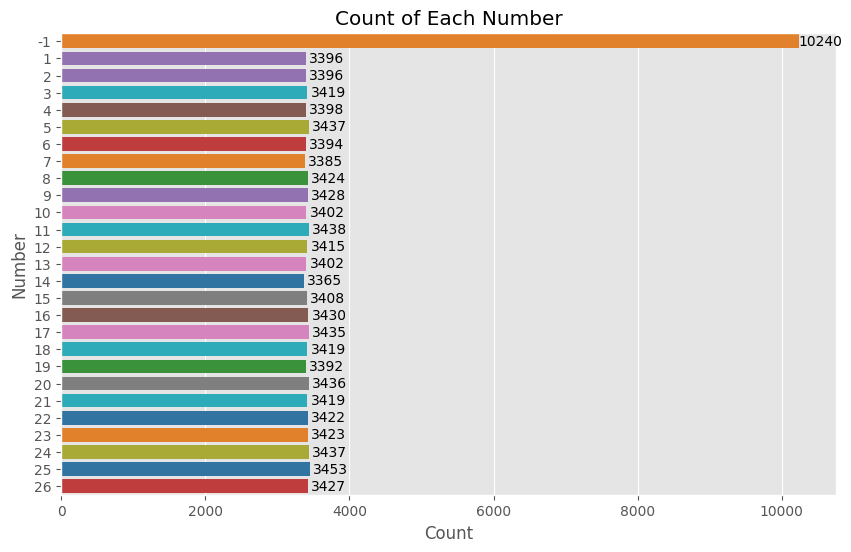

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 -1 
Count of unique classes: 27


In [ ]:
unique, counts = np.unique(y, return_counts=True)
data = pd.DataFrame({'Number': unique, 'Count': counts})


plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Count', y='Number', data=data, palette='tab10', orient='h', hue=counts, legend=False)

# Add annotation (count) for each bar
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'center', va = 'center',
                     xytext = (15, 0),  # Offset the text a bit to the right
                     textcoords = 'offset points')

plt.title('Count of Each Number')
plt.xlabel('Count')
plt.ylabel('Number')
plt.show()

# Showing the classes
for clas in list(set(y)):
    print(clas, end=' ')
print(f"\nCount of unique classes: {len(set(y))}")

**<u>Observation</u>**:
- Dataset is reasonably balanced between the 26 letters
- There are 27 unique classes even though there are only 26 letters!!
    - This is because class (-1) is empty

### **Class (*-1*)**

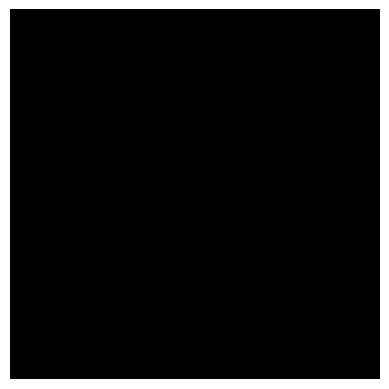

In [ ]:
plt.imshow(X[y == -1][0], cmap='gray')
plt.axis('off')
plt.show()

### **First 5 Examples of the letters from the dataset**

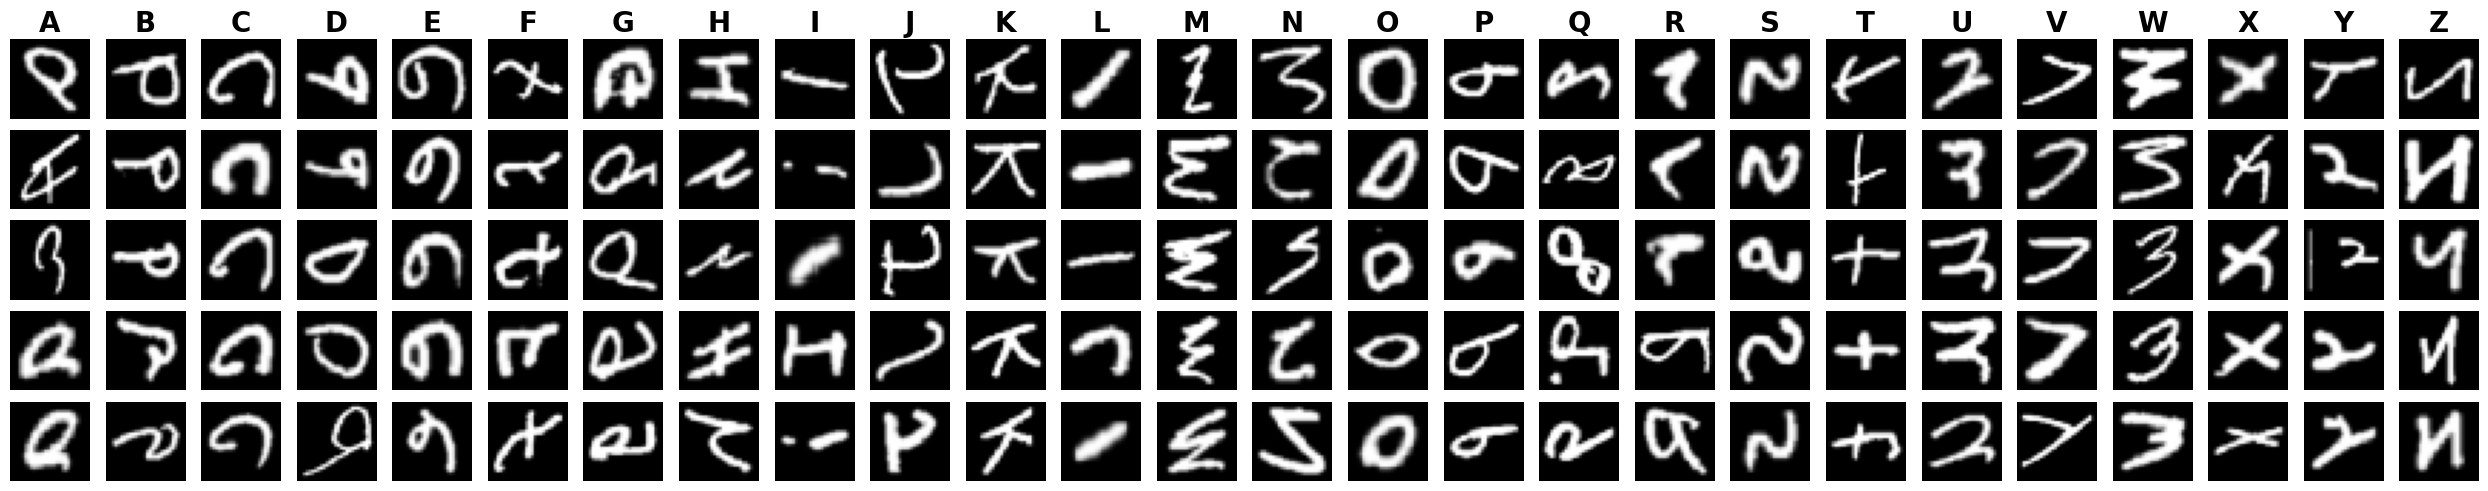

In [ ]:
num_classes = 26
fig, ax = plt.subplots(5, 26, figsize=(25,5))
letters = 'abcdefghijklmnopqrstuvwxyz'.upper()

for letter in range(num_classes):
    for _ in range(5):
        ax[_][letter].imshow(X[y == letter+1][_], cmap='gray')
        ax[_][letter].axis('off')
    ax[0][letter].set_title(letters[letter], fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

**<u>Observation</u>**:
- Letters have both **uppercase** & **lowercase** in the same class!!
- Letters are in a `Bad Orientation`!

## **Image Average**

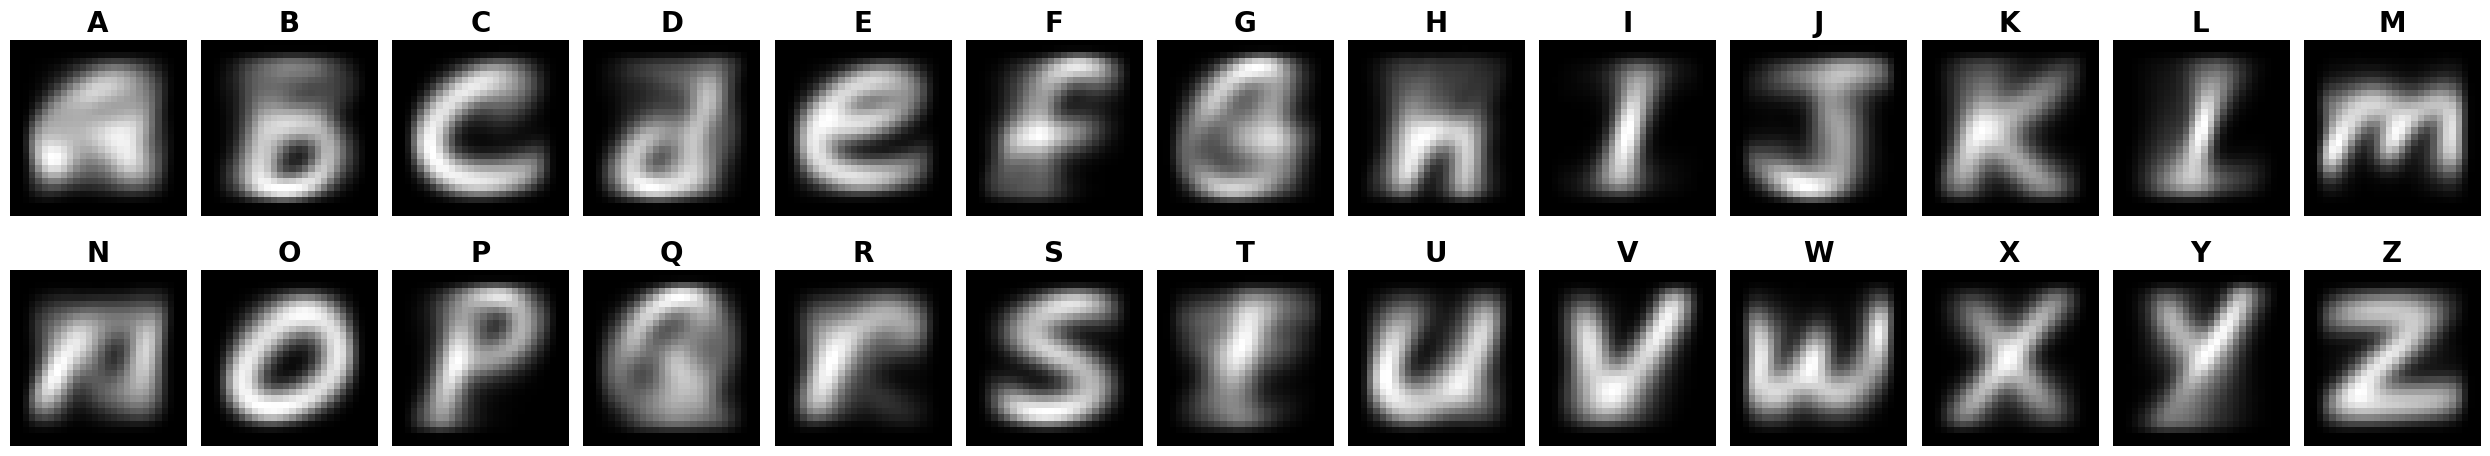

In [ ]:
num_classes = 26
fig, ax = plt.subplots(2, 13, figsize=(25,5))
letters = 'abcdefghijklmnopqrstuvwxyz'.upper()
half = 0
for letter in range(num_classes):
    if letter == 13:
        half = 1
    ax[half][letter%13].imshow(np.mean([img for img in X[y == letter+1]], axis=0), cmap='gray')
    ax[half][letter%13].axis('off')
    ax[half][letter%13].set_title(letters[letter], fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

**<u>Observation</u>**:
- Letters where the `capitalization` of it `differs largely` from upper & lower **(A,B,H,N,Q,R,T)**
    - The Average of it is blury and hard to distinguish the letter
    - Hard to see distinct features of the letter

## **t-Distributed Stochastic Neighbor Embedding (`t-SNE`)**
- ***Dimensionality Reduction***: Maps high-dimensional data to 2 or 3 dimensions while preserving relative distances.
- ***Probability Distributions***: Uses Gaussian distributions in high dimensions and Student's t-distributions in low dimensions to calculate similarities.
- ***Optimization***: Minimizes Kullback-Leibler divergence to ensure low-dimensional representation reflects the high-dimensional structure.

### **Use Cases**

- ***Visualizing Latent Space***: Projects high-dimensional latent space into 2D/3D, making it easier to visualize and understand GAN outputs.
- ***Understanding Variations***: Helps in observing clusters and patterns corresponding to different types of generated images.
- ***Detecting Mode Collapse***: Identifies if GANs are producing diverse outputs or collapsing into few clusters.
- ***Analyzing Training Progress***: Visualizes the evolution of generated images over time, aiding in diagnosing issues and comparing training stages.

### **How t-SNE Works**

1. ***Compute Pairwise Affinities***: In high dimensions using Gaussian distributions.
2. ***Define Affinities in Low-Dimensional Space***: Using Student's t-distributions.
3. ***Minimize Divergence***: Uses gradient descent to optimize point placement in low-dimensional space.

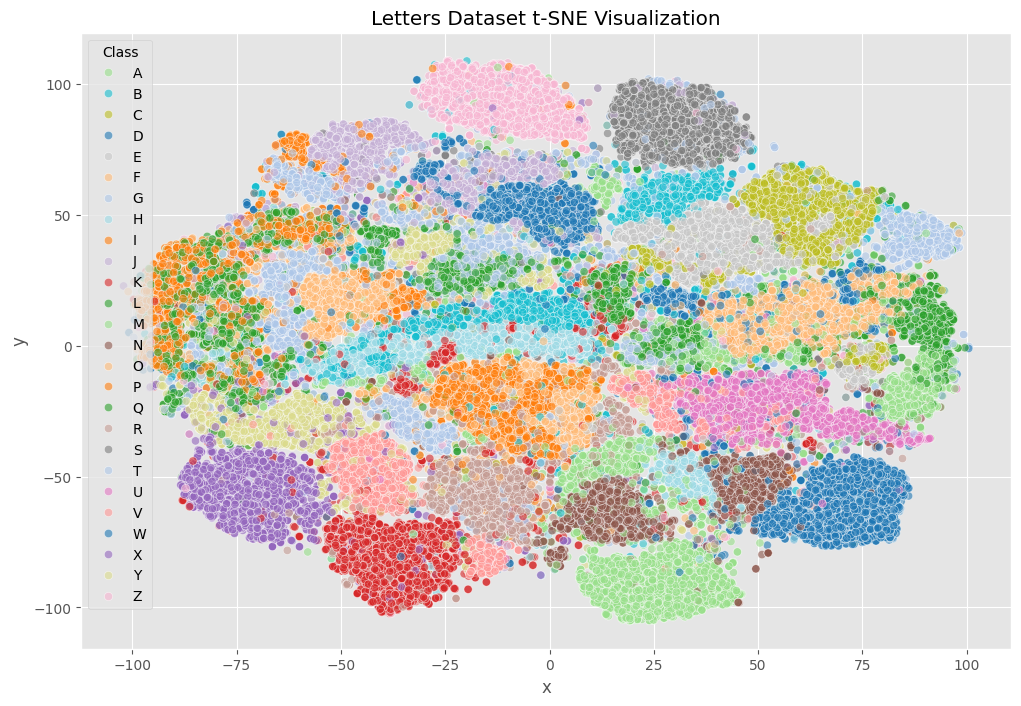

In [6]:
TSNE_data = data[data[0] != -1]
x_Features = TSNE_data.iloc[:, 1:].values     # Features
y_Labels = TSNE_data.iloc[:, 0].values        # Labels


# Map numbers 1-26 to letters A-Z
label_map = {i: chr(64 + i).upper() for i in range(1, 27)}
y_Labels = np.array([label_map[label] for label in y_Labels])

# Normalize the data
x_Features = x_Features / 255.0

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(x_Features)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(tsne_result, columns=['x', 'y'])
tsne_df['label'] = y_Labels

# Plot t-SNE result
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='x', y='y', hue='label', palette='tab20', data=tsne_df, legend='full', alpha=0.6)
plt.title('Letters Dataset t-SNE Visualization')

# Adjust legend to display letters A-Z in order
handles, labels = scatter.get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: labels[k])
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='best', title='Class', ncol=1)

plt.show()

**<u>Observation</u>**:
- We can better see the distribution of classes
- Letters with their `Capitalized` counterpart
    - **Big difference** seem to have `2` Clusters (e.g [D > Blue])
    - **Small difference** seem to have `1` Cluster (e.g [S > Gray], [X > Purple])

<hr>

# **Feature Engineering**
- ReOrientating Images
- Normalization
- Data Augmentation

<hr>

### **ReOrientating Images**
The Shape of X is (Count, Width, Height)<br>
X.transpose(0, 2, 1) ReOrders the Dimensions which **swapped the Width & Height**<br>
This will then allow us to **reorientate** our images so that our model can train with the right data

In [ ]:
# ReOrientation of the Image
X = X.transpose(0, 2, 1)

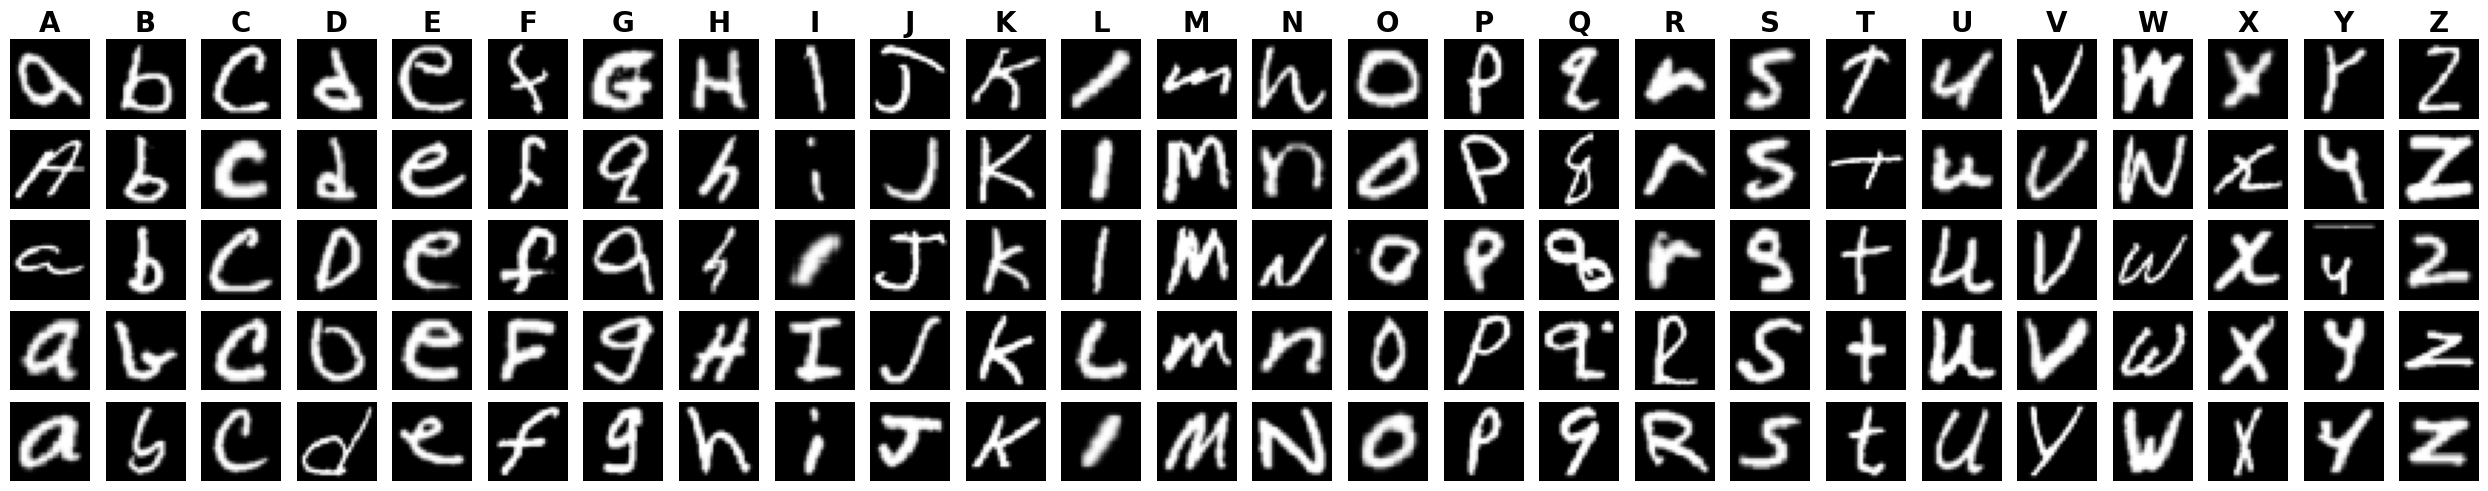

In [ ]:
num_classes = 26
fig, ax = plt.subplots(5, 26, figsize=(25,5))
letters = 'abcdefghijklmnopqrstuvwxyz'.upper()

for letter in range(num_classes):
    for _ in range(5):
        ax[_][letter].imshow(X[y == letter+1][_], cmap='gray')
        ax[_][letter].axis('off')
    ax[0][letter].set_title(letters[letter], fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

<hr>

### **Normalization**

Normalization helps stabilize training by keeping the activation values within a manageable range, preventing them from becoming too large or too small<br>
Normalizing inputs to [-1, 1] aligns well with these activation functions, allowing them to operate optimally without **saturating** or **losing gradients** in deeper layers.<br>


The `tanh activation function`, which is commonly used in GANs, outputs values in the range [-1, 1] when its input is within that range
the outputs of the generator are naturally constrained to a range that matches the discriminator's expectations.<br>

- **Generator Output**: Typically, the output of the generator (which generates fake images) uses tanh activation to produce pixel values in the range **[-1, 1]**
- **Discriminator Input**: Real and fake images (inputs to the discriminator) are normalized to **[-1, 1]** to ensure consistent evaluation

In summary, normalization to the range [-1, 1] in GANs is crucial for stabilizing training, ensuring effective use of activation functions, and promoting convergence of both the generator and discriminator networks. This practice leverages the properties of activation functions like tanh and aligns well with the challenges and requirements of training deep neural networks, especially in adversarial settings like GANs.

In [ ]:
# Reshaping the Image Between -1 and 1
X = (X - 127.5) / 127.5

<hr>

### **Data Augmentation**
Data augmentation is a technique used to artificially expand the size and diversity of a training dataset by creating modified versions of existing data. In the context of image processing and machine learning, this often involves applying various transformations to images.

<u>**Geometric Transformations:**</u>
- Rotation
- Scaling (zoom)
- Translation
- Flipping
- Shearing

## **Noise Injection:**

<u>**Gaussian Noise**</u><br>

- Gaussian noise, or normal noise, follows a normal distribution and adds random variations to pixel intensities. It is characterized by two parameters: the mean (typically set to 0) and the standard deviation (σ), which controls the noise's strength.
- **Advantages:**
    - Helps simulate electronic sensor noise or low-light conditions.
    - Enhances model robustness to slight variations in pixel intensities, aiding in the development of more adaptable machine learning models.

<u>**Salt and Pepper Noise**</u><br>

- Salt and Pepper noise, also known as impulse noise, randomly sets a small percentage of image pixels to either the maximum value (salt) or minimum value (pepper), creating sparse light and dark disturbances.
- **Advantages:**
    - Useful for simulating specific image defects like malfunctioning camera pixels.
    - Assists in making models robust to sharp, isolated disturbances, improving their ability to handle such imperfections in real-world data.

In summary, these types of noise are used to create realistic variations in training data, helping models generalize better to unseen scenarios. Gaussian noise is good for simulating overall image quality degradation, while Salt and Pepper noise is more focused on handling isolated pixel-level errors. The application and intensity of these noises should be balanced to maintain important image features while introducing beneficial variability.

In [20]:
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Ensure values are between 0 and 1

def add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy_image = np.copy(image)
    # Add salt noise
    salt_mask = np.random.random(image.shape) < salt_prob
    noisy_image[salt_mask] = 1
    # Add pepper noise
    pepper_mask = np.random.random(image.shape) < pepper_prob
    noisy_image[pepper_mask] = 0
    return noisy_image

def plot_original_and_noisy(original, gaussian_noisy, sp_noisy, label):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    ax1.imshow(original, cmap='gray')
    ax1.set_title(f'Original (Class: {label})')
    ax1.axis('off')
    
    ax2.imshow(gaussian_noisy, cmap='gray')
    ax2.set_title('Gaussian Noise')
    ax2.axis('off')
    
    ax3.imshow(sp_noisy, cmap='gray')
    ax3.set_title('Salt and Pepper Noise')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

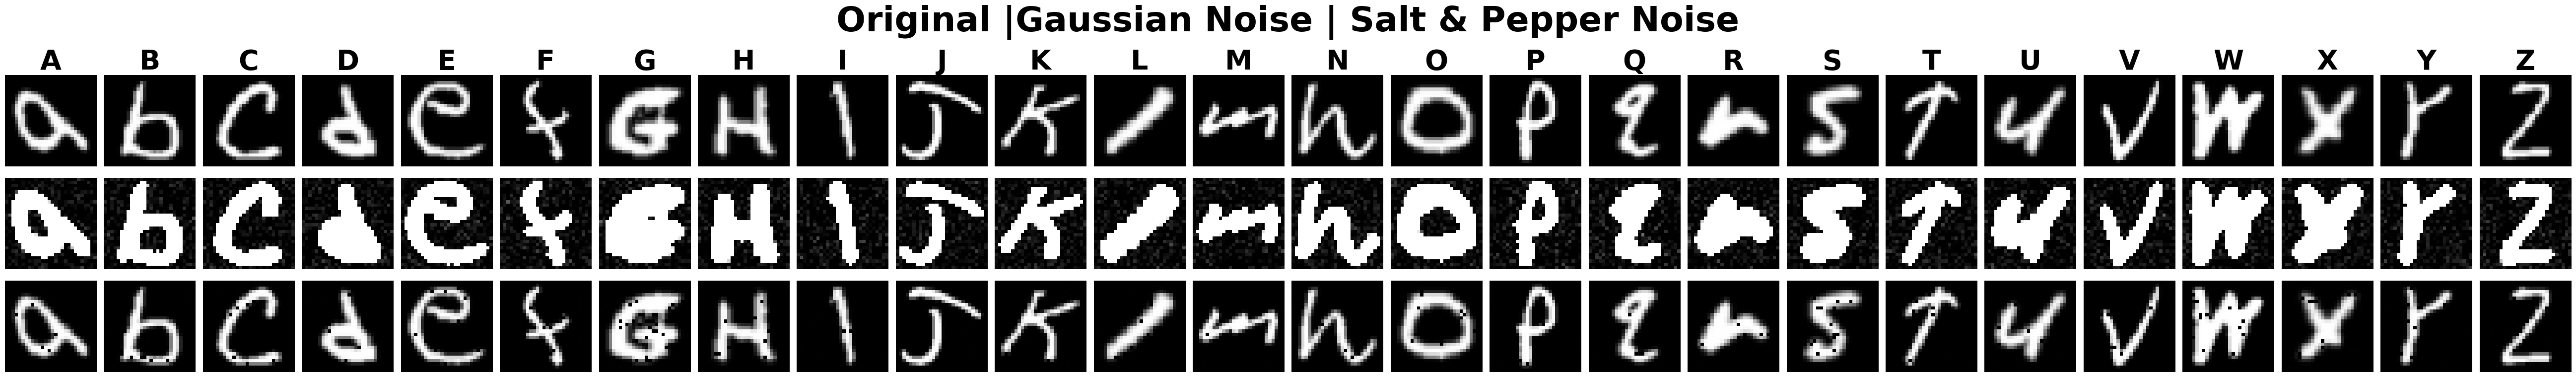

In [28]:
images = data.iloc[:, 1:].values
labels = data.iloc[:, 0].values

images_2d = images.reshape(-1, 28, 28)      # Reshape images to 2D
images_2d = images_2d.transpose(0, 2, 1)    # Transpose

# Get unique classes present in the dataset
unique_classes = np.unique(labels)
num_classes = len(unique_classes)

# Create a 3xnum_classes subplot
fig, axs = plt.subplots(3, num_classes, figsize=(2*num_classes, 8))
fig.suptitle('Original |Gaussian Noise | Salt & Pepper Noise', fontsize=50, fontweight='bold')

letters = "abcdefghijklmnopqrstuvwxyz"
for idx, class_label in enumerate(unique_classes):


    # Find the first image of this class
    image_idx = np.where(labels == class_label)[0][0]
    original_image = images_2d[image_idx]
    
    # Apply noise
    gaussian_noisy_image = add_gaussian_noise(original_image)
    sp_noisy_image = add_salt_and_pepper_noise(original_image)
    
    # Plot original image
    axs[0, idx].imshow(original_image, cmap='gray')
    axs[0, idx].set_title(letters[idx].upper(), fontsize=40, fontweight='bold')
    axs[0, idx].axis('off')
    
    # Plot Gaussian noise image
    axs[1, idx].imshow(gaussian_noisy_image, cmap='gray')
    axs[1, idx].axis('off')
    
    # Plot Salt and Pepper noise image
    axs[2, idx].imshow(sp_noisy_image, cmap='gray')
    axs[2, idx].axis('off')


plt.tight_layout()
plt.show()

In [22]:
def augment_data(data):
    images = data.iloc[:, 1:].values
    labels = data.iloc[:, 0].values

    images_2d = images.reshape(-1, 28, 28)      # Reshape images to 2D
    images_2d = images_2d.transpose(0, 2, 1)    # Transpose

    augmented_images = []
    augmented_labels = []
    
    for image, label in zip(images_2d, labels):
        # Add original image
        augmented_images.append(image.flatten())
        augmented_labels.append(label)
        
        # Add Gaussian noisy image
        gaussian_noisy = add_gaussian_noise(image)
        augmented_images.append(gaussian_noisy.flatten())
        augmented_labels.append(label)
        
        # Add Salt and Pepper noisy image
        sp_noisy = add_salt_and_pepper_noise(image)
        augmented_images.append(sp_noisy.flatten())
        augmented_labels.append(label)
    
    augmented_images = np.array(augmented_images)
    augmented_data = np.column_stack((augmented_labels, augmented_images))
    
    return augmented_data

In [23]:
augmented_data = augment_data(data)

print(f"Original data size: {data.shape[0]}")
print(f"Augmented data size: {augmented_data.shape[0]}")

Original data size: 88800
Augmented data size: 266400


<hr>

# **Generative Adversarial Network (GAN) Architecture**

Generative Adversarial Networks (GANs) are a class of machine learning frameworks designed for generating new data samples that resemble a given dataset. Introduced by Ian Goodfellow et al. in 2014, GANs consist of two neural networks, the **Generator** and the **Discriminator**, which compete against each other in a game-theoretic framework.
<br><br>
<hr>

## **Components of GANs**

### <u>Generator</u>

The Generator's objective is to produce realistic data samples from *random noise*. It learns to map input noise (usually sampled from a Gaussian or uniform distribution) into a target data distribution.

- **Input**: A random vector (noise).
- **Output**: A synthetic data sample (e.g., an image).
- **Architecture**: Typically composed of several layers, including dense layers, reshaping layers, and convolutional layers. The architecture can vary depending on the type of data being generated.

### <u>Discriminator</u>

The Discriminator's goal is to distinguish between real data samples from the dataset and fake samples generated by the Generator. It outputs a probability indicating whether a given input is real or fake.

- **Input**: A data sample (either real or generated).
- **Output**: A binary classification (real or fake).
- **Architecture**: Usually consists of convolutional layers followed by flattening and dense layers.
<br><br>
<hr>

## **GAN Training Process**
The training of GANs involves a two-step process, iteratively updating both networks:


### **Generator Training**:
   - Generate a batch of fake samples using the current Generator.
   - Train the Generator using the Discriminator's feedback to maximize the probability of the Discriminator classifying its samples as real.
   - Update the Generator’s weights to produce more realistic samples over time.
### **Discriminator Training**:
   - Train on a batch of real samples from the dataset.
   - Train on a batch of fake samples generated by the Generator.
   - Update the Discriminator’s weights to improve its ability to differentiate real from fake.

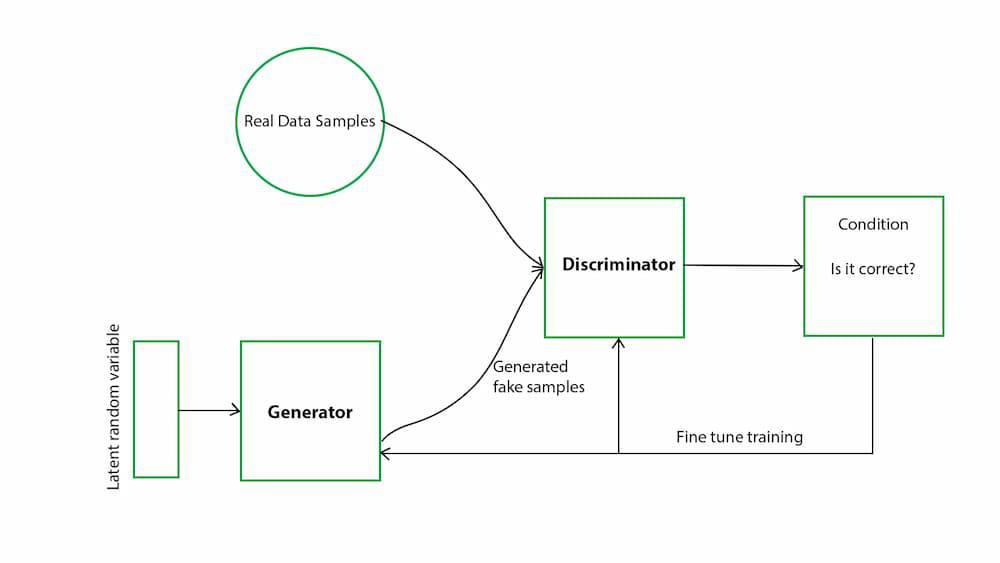<br><br>
This adversarial process continues until the Generator produces samples indistinguishable from real data or until a predefined number of iterations is reached.<br>
<hr>

## **GAN Architecture Overview**

| Component       | Description                                   |
|------------------|-----------------------------------------------|
| **Generator**     | Transforms random noise into data samples     |
| **Discriminator** | Classifies samples as real or fake            |

<br>
<hr>

# **Model Training**

**Types of GANs**
- DCGAN
- cGAN
- TripleGAN

In [5]:
data = pd.read_csv('./CA2-Data/emnist-letters-train.csv', header=None)
data = data[data[0] != -1]
data.head()

0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    7    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   16    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]

# **Processing Data**

In [6]:
augment_data = augment_data(data)       # Augment the data

X = augment_data.iloc[:, 1:].values     # image data
y = augment_data.iloc[:, 0].values      # Classes

X = X.reshape(len(X), 28, 28)
X = X.transpose(0, 2, 1)

BUFFER_SIZE = len(X)
BATCH_SIZE = 256

X = X.reshape(-1, 28, 28, 1)  # Add channel dimension
X = (X - 127.5) / 127.5 # Normalize the images to [-1, 1]

x_train = tf.data.Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_train = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<hr>

# **Baseline Model** (**`DCGAN`**)

A DCGAN (Deep Convolutional Generative Adversarial Network) is a type of GAN (Generative Adversarial Network) that uses deep convolutional networks in both the generator and the discriminator. The use of convolutional layers, which are better suited for image data, providing spatial hierarchies and translation invariance.

## **Key Components of DCGAN**
<u>**Convolutional Layers**</u>
- **Discriminator**: Extract hierarchical features from images.
- **Generator**: Generate images with spatial structure.

<u>**Transposed Convolutional Layers**</u>
- Used in the generator to upsample from a lower-dimensional space to the image space.

In [ ]:
class DCGAN:
    def __init__(self, noise_dim=100, num_examples_to_generate=16, epochs=5, batch_size=256):
        self.noise_dim = noise_dim
        self.num_examples_to_generate = num_examples_to_generate
        self.epochs = epochs
        self.batch_size = batch_size
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_dim])
        self.epoch_images = []
        self.history = {
            'gen_loss_history': [],
            'disc_loss_history': [],
            'average_fid_history': [],
            'kl_divergence_history': [],
        }
        self.inception_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

    def make_generator_model(self):
        model = tf.keras.Sequential()
        model.add(Dense(7*7*256, use_bias=False, input_shape=(self.noise_dim,)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Reshape((7, 7, 256)))
        model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        return model

    def make_discriminator_model(self):
        model = tf.keras.Sequential()
        model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
        model.add(LeakyReLU())
        model.add(Dropout(0.3))

        model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        model.add(LeakyReLU())
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        return model

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def calculate_kl_divergence(self, p, q):
        # Ensure inputs are at least 2D
        p = tf.reshape(p, [-1, 1])
        q = tf.reshape(q, [-1, 1])

        # Clip values to avoid log(0)
        epsilon = 1e-10
        p = tf.clip_by_value(p, epsilon, 1.0)
        q = tf.clip_by_value(q, epsilon, 1.0)

        kl_div = tf.reduce_mean(p * (tf.math.log(p) - tf.math.log(q)))
        return kl_div

    def calculate_fid(self, real_images, fake_images):
        real_images_resized = tf.image.resize(real_images, [75, 75])
        fake_images_resized = tf.image.resize(fake_images, [75, 75])

        real_images_resized = tf.expand_dims(real_images_resized, axis=-1)
        fake_images_resized = tf.expand_dims(fake_images_resized, axis=-1)

        real_images_rgb = tf.image.grayscale_to_rgb(real_images_resized)
        fake_images_rgb = tf.image.grayscale_to_rgb(fake_images_resized)

        real_images_rgb_shaped = tf.reshape(real_images_rgb, [-1, 75, 75, 3])
        fake_images_rgb_shaped = tf.reshape(fake_images_rgb, [-1, 75, 75, 3])

        real_images_rgb_processed = preprocess_input(real_images_rgb_shaped)
        fake_images_rgb_processed = preprocess_input(fake_images_rgb_shaped)

        real_features = self.inception_model(real_images_rgb_processed)
        fake_features = self.inception_model(fake_images_rgb_processed)

        mu_real = np.mean(real_features, axis=0)
        sigma_real = np.cov(real_features, rowvar=False)
        mu_fake = np.mean(fake_features, axis=0)
        sigma_fake = np.cov(fake_features, rowvar=False)
        fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(np.dot(sigma_real, sigma_fake)))

        return fid

    @tf.function
    def train_step(self, images):
        batch_size = tf.shape(images)[0]
        noise = tf.random.normal([batch_size, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

            # Calculate KL divergence
            kl_div = self.calculate_kl_divergence(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return gen_loss, disc_loss, kl_div

    def generate_and_save_images(self, model, test_input):
        predictions = model(test_input, training=False)

        fig = plt.figure(figsize=(8, 8))
        images = []
        for i in range(predictions.shape[0]):
            plt.suptitle(f"DCGAN\nGenerated Images", fontsize=20, fontweight='bold')
            plt.tight_layout(rect=[0, 0.1, 1, 0.95])
            plt.subplot(8, 8, i + 1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        else:
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            images.append(image)

        plt.show()
        self.epoch_images.extend(images)

    def generate_GIF(self):
        imageio.mimsave("./CA2-Output/GAN-Generated_Images/Training/DCGAN_Training.gif", self.epoch_images, duration=1)

    def plot_losses_fid_kld(self):
        fig = plt.figure(figsize=(20, 10))
        gs = GridSpec(2, 2, height_ratios=[1, 1])

        ax_top = fig.add_subplot(gs[0, :])
        ax_top.plot(self.history['gen_loss_history'], label='Generator Loss', color='blue')
        ax_top.plot(self.history['disc_loss_history'], label='Discriminator Loss', color='orange')
        ax_top.set_ylabel('Loss')
        ax_top.legend()
        ax_top.set_title('Generator and Discriminator Loss During Training', fontsize=16, fontweight='bold')

        ax_bottom_left = fig.add_subplot(gs[1, 0])
        ax_bottom_left.plot(self.history['average_fid_history'], label='FID', color='blue')
        ax_bottom_left.set_xlabel('Epochs')
        ax_bottom_left.set_ylabel('FID')
        ax_bottom_left.set_title('Fréchet Inception Distance During Training', fontsize=16, fontweight='bold')
        ax_bottom_left.legend(loc='upper left')

        ax_bottom_right = fig.add_subplot(gs[1, 1])
        ax_bottom_right.plot(self.history['kl_divergence_history'], label='KL Divergence', color='green')
        ax_bottom_right.set_xlabel('Epochs')
        ax_bottom_right.set_ylabel('KL Divergence')
        ax_bottom_right.set_title('KL Divergence During Training', fontsize=16, fontweight='bold')
        ax_bottom_right.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

    def train(self, dataset):
        for epoch in range(self.epochs):
            start = time.time()
            gen_losses = []
            disc_losses = []
            kl_divs = []
            for image_batch in tqdm(dataset):
                gen_loss, disc_loss, kl_div = self.train_step(image_batch)
                gen_losses.append(gen_loss)
                disc_losses.append(disc_loss)
                kl_divs.append(kl_div)

            self.history['gen_loss_history'].append(np.mean(gen_losses))
            self.history['disc_loss_history'].append(np.mean(disc_losses))
            self.history['kl_divergence_history'].append(np.mean(kl_divs))

            display.clear_output(wait=True)
            self.generate_and_save_images(self.generator, self.seed)

            # Calculate FID
            all_real_images = []
            all_fake_images = []
            for image_batch in dataset.take(4):
                noise = tf.random.normal([tf.shape(image_batch)[0], self.noise_dim])
                generated_images = self.generator(noise, training=False)

                all_real_images.append(image_batch)
                all_fake_images.append(tf.squeeze(generated_images, axis=-1))

            all_real_images = tf.concat(all_real_images, axis=0)
            all_fake_images = tf.concat(all_fake_images, axis=0)

            average_fid = self.calculate_fid(all_real_images, all_fake_images)
            self.history['average_fid_history'].append(average_fid)

            print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

        self.generate_GIF()
        self.plot_losses_fid_kld()

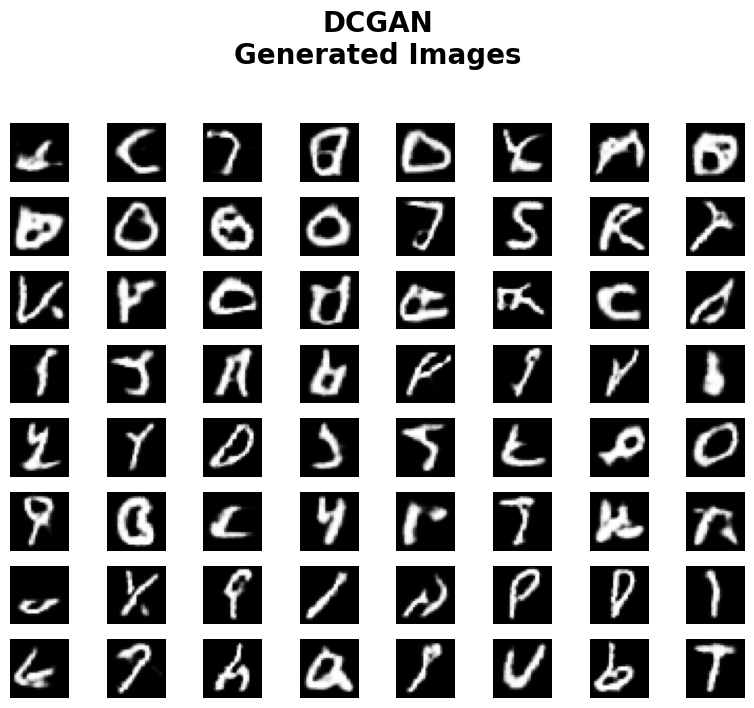

Time for epoch 100 is 18.10949444770813 sec


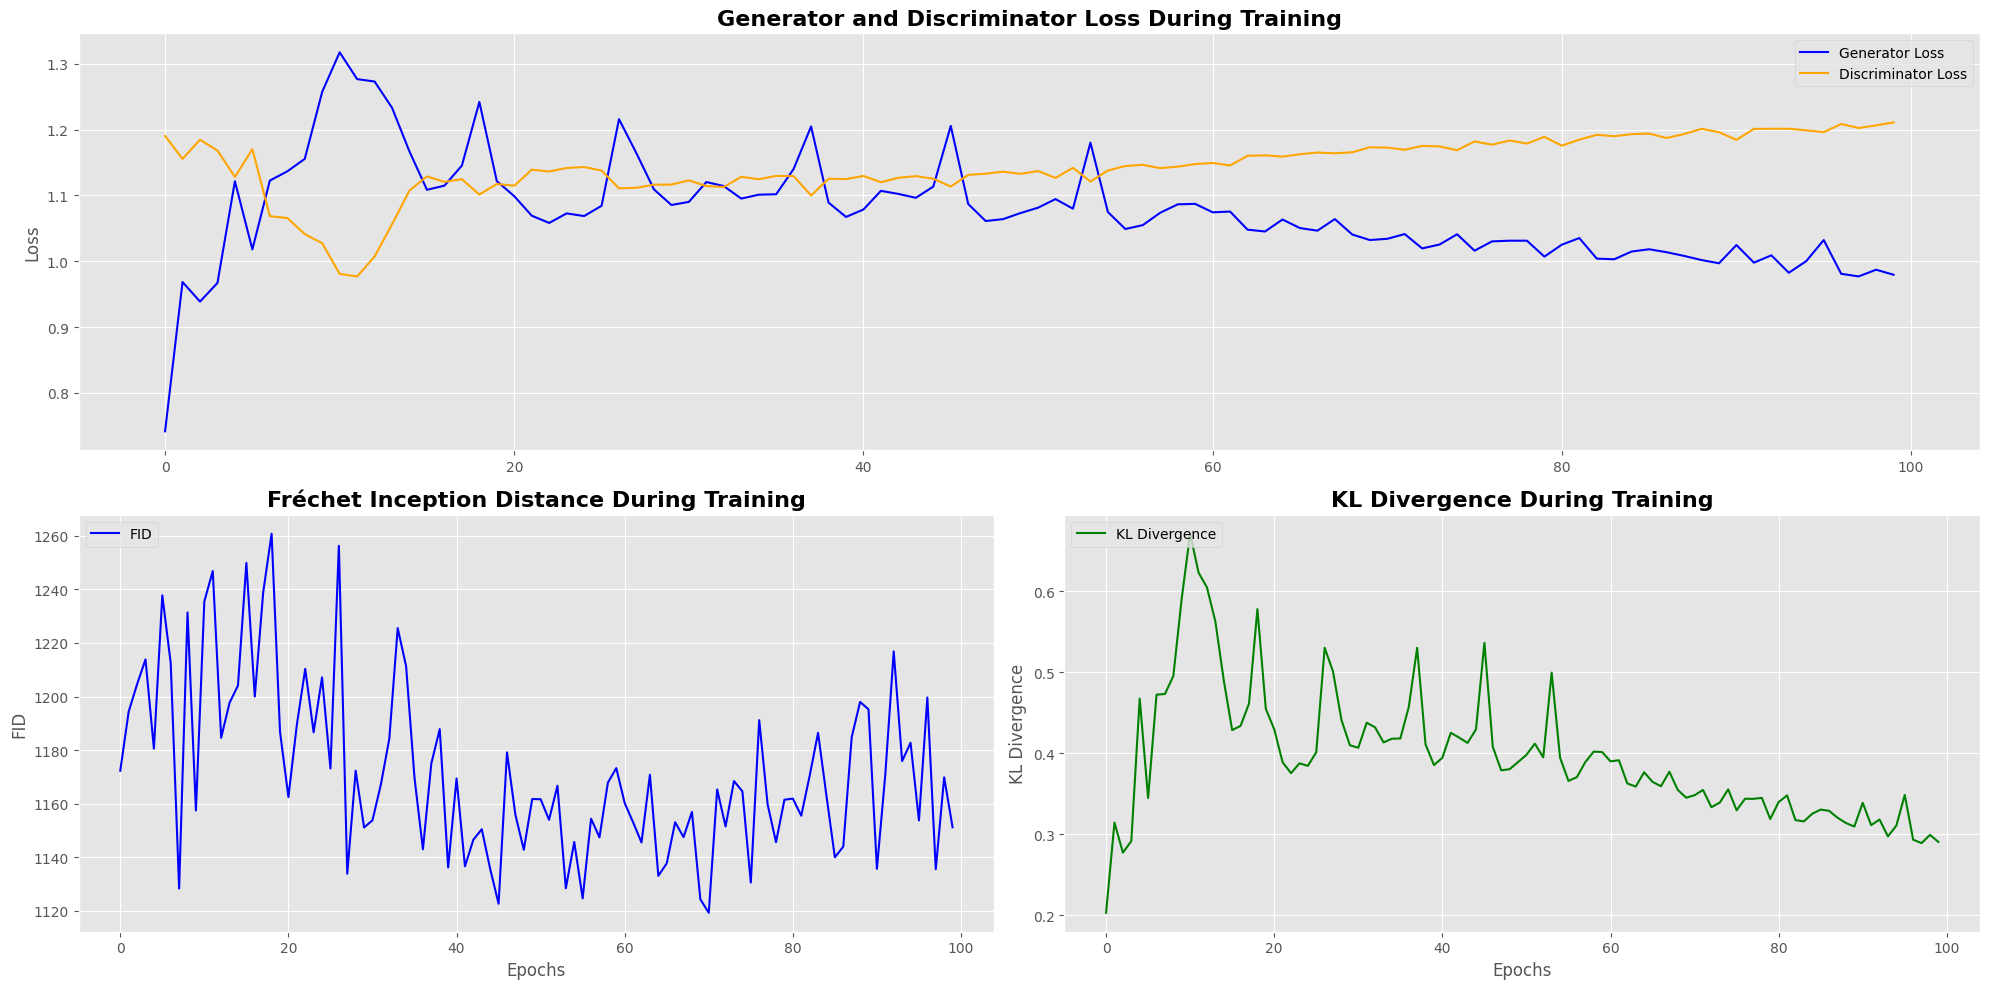

In [ ]:
dcgan = DCGAN(epochs=100, num_examples_to_generate=64, noise_dim=100)
dcgan.train(x_train)

<u>Observation:</u>

- the Discriminator & Generator loss started to stablize after the 40th epoch.
- Discriminator & Generator loss are diverging. `(Discriminator too strong)`
- FID is fluctuating but KL Divergence is slowly decreasing. which shows the generated images are starting to look like real images

# **Improved DCGAN**
1. **Residual Blocks:**
   - Utilizes residual blocks with skip connections. These connections help in stabilizing the training by allowing gradients to flow more easily through the network.

2. **Complexity and Depth:**
   - Introduces more convolutional layers within each block, which allows for capturing more complex features.

3. **Batch Normalization:**
   - Applies batch normalization after each convolutional layer within the residual blocks, which helps in stabilizing and speeding up the training process.

4. **Flexibility:**
   - Uses the functional API, making the architecture more flexible and easier to modify.


In [ ]:
class Enhanced_DCGAN:
    def __init__(self, noise_dim=100, num_examples_to_generate=16, epochs=5, batch_size=256):
        self.noise_dim = noise_dim
        self.num_examples_to_generate = num_examples_to_generate
        self.epochs = epochs
        self.batch_size = batch_size
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_dim])
        self.epoch_images = []
        self.history = {
            'gen_loss_history': [],
            'disc_loss_history': [],
            'average_fid_history': [],
            'kl_divergence_history': [],
        }
        self.inception_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

    def make_generator_model(self):
        noise_input = Input(shape=(self.noise_dim,))

        # Initial dense layer
        initial_dense = Dense(7*7*256, use_bias=False)(noise_input)
        initial_bn = BatchNormalization()(initial_dense)
        initial_leaky = LeakyReLU(alpha=0.2)(initial_bn)

        reshaped_features = Reshape((7, 7, 256))(initial_leaky)

        # Transposed Convolution blocks with residual connections
        def residual_block(input_tensor, filter_count, stride_size):
            skip_connection = input_tensor

            conv1 = Conv2DTranspose(filter_count, (3, 3), strides=stride_size, padding='same', use_bias=False)(input_tensor)
            bn1 = BatchNormalization()(conv1)
            leaky1 = LeakyReLU(alpha=0.2)(bn1)

            conv2 = Conv2DTranspose(filter_count, (3, 3), strides=(1, 1), padding='same', use_bias=False)(leaky1)
            bn2 = BatchNormalization()(conv2)

            if stride_size != (1, 1) or int(skip_connection.shape[-1]) != filter_count:
                skip_connection = Conv2DTranspose(filter_count, (1, 1), strides=stride_size, padding='same', use_bias=False)(skip_connection)

            added = Add()([bn2, skip_connection])
            output = LeakyReLU(alpha=0.2)(added)
            return output

        block1 = residual_block(reshaped_features, 128, (2, 2))
        block2 = residual_block(block1, 64, (2, 2))

        # Final convolution
        final_conv = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(block2)
        final_bn = BatchNormalization()(final_conv)
        final_leaky = LeakyReLU(alpha=0.2)(final_bn)

        output_img = Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(final_leaky)

        return Model(inputs=noise_input, outputs=output_img, name="Generator")

    def make_discriminator_model(self):
        img_input = Input(shape=[28, 28, 1])

        def conv_block(input_tensor, filter_count, stride_size):
            conv1 = Conv2D(filter_count, (3, 3), strides=stride_size, padding='same')(input_tensor)
            leaky1 = LeakyReLU(alpha=0.2)(conv1)
            conv2 = Conv2D(filter_count, (3, 3), strides=(1, 1), padding='same')(leaky1)
            leaky2 = LeakyReLU(alpha=0.2)(conv2)
            return leaky2

        # Convolutional blocks
        conv_block1 = conv_block(img_input, 64, (2, 2))
        dropout1 = Dropout(0.3)(conv_block1)

        conv_block2 = conv_block(dropout1, 128, (2, 2))
        dropout2 = Dropout(0.3)(conv_block2)

        conv_block3 = conv_block(dropout2, 256, (2, 2))
        dropout3 = Dropout(0.3)(conv_block3)

        # Global average pooling
        global_pool = GlobalAveragePooling2D()(dropout3)

        # Dense layers
        dense1 = Dense(512)(global_pool)
        leaky_dense1 = LeakyReLU(alpha=0.2)(dense1)
        dropout4 = Dropout(0.5)(leaky_dense1)

        dense2 = Dense(256)(dropout4)
        leaky_dense2 = LeakyReLU(alpha=0.2)(dense2)
        dropout5 = Dropout(0.5)(leaky_dense2)

        validity = Dense(1, activation='sigmoid')(dropout5)

        return Model(inputs=img_input, outputs=validity, name="Discriminator")

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def calculate_kl_divergence(self, p, q):
        # Ensure inputs are at least 2D
        p = tf.reshape(p, [-1, 1])
        q = tf.reshape(q, [-1, 1])

        # Clip values to avoid log(0)
        epsilon = 1e-10
        p = tf.clip_by_value(p, epsilon, 1.0)
        q = tf.clip_by_value(q, epsilon, 1.0)

        kl_div = tf.reduce_mean(p * (tf.math.log(p) - tf.math.log(q)))
        return kl_div

    def calculate_fid(self, real_images, fake_images):
        real_images_resized = tf.image.resize(real_images, [75, 75])
        fake_images_resized = tf.image.resize(fake_images, [75, 75])

        real_images_resized = tf.expand_dims(real_images_resized, axis=-1)
        fake_images_resized = tf.expand_dims(fake_images_resized, axis=-1)

        real_images_rgb = tf.image.grayscale_to_rgb(real_images_resized)
        fake_images_rgb = tf.image.grayscale_to_rgb(fake_images_resized)

        real_images_rgb_shaped = tf.reshape(real_images_rgb, [-1, 75, 75, 3])
        fake_images_rgb_shaped = tf.reshape(fake_images_rgb, [-1, 75, 75, 3])

        real_images_rgb_processed = preprocess_input(real_images_rgb_shaped)
        fake_images_rgb_processed = preprocess_input(fake_images_rgb_shaped)

        real_features = self.inception_model(real_images_rgb_processed)
        fake_features = self.inception_model(fake_images_rgb_processed)

        mu_real = np.mean(real_features, axis=0)
        sigma_real = np.cov(real_features, rowvar=False)
        mu_fake = np.mean(fake_features, axis=0)
        sigma_fake = np.cov(fake_features, rowvar=False)
        fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(np.dot(sigma_real, sigma_fake)))

        return fid

    @tf.function
    def train_step(self, images):
        batch_size = tf.shape(images)[0]
        noise = tf.random.normal([batch_size, self.noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

            # Calculate KL divergence
            kl_div = self.calculate_kl_divergence(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return gen_loss, disc_loss, kl_div

    def generate_and_save_images(self, model, test_input):
        predictions = model(test_input, training=False)

        fig = plt.figure(figsize=(8, 8))
        images = []
        for i in range(predictions.shape[0]):
            plt.suptitle(f"Enhanced DCGAN\nGenerated Images", fontsize=20, fontweight='bold')
            plt.tight_layout(rect=[0, 0.1, 1, 0.95])
            plt.subplot(8, 8, i + 1)
            plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        else:
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            images.append(image)

        plt.show()
        self.epoch_images.extend(images)

    def generate_GIF(self):
        imageio.mimsave("./CA2-Output/GAN-Generated_Images/Training/EnhancedDCGAN_Training.gif", self.epoch_images, duration=1)

    def plot_losses_fid_kld(self):
        fig = plt.figure(figsize=(20, 10))
        gs = GridSpec(2, 2, height_ratios=[1, 1])

        ax_top = fig.add_subplot(gs[0, :])
        ax_top.plot(self.history['gen_loss_history'], label='Generator Loss', color='blue')
        ax_top.plot(self.history['disc_loss_history'], label='Discriminator Loss', color='orange')
        ax_top.set_ylabel('Loss')
        ax_top.legend()
        ax_top.set_title('Generator and Discriminator Loss During Training', fontsize=16, fontweight='bold')

        ax_bottom_left = fig.add_subplot(gs[1, 0])
        ax_bottom_left.plot(self.history['average_fid_history'], label='FID', color='blue')
        ax_bottom_left.set_xlabel('Epochs')
        ax_bottom_left.set_ylabel('FID')
        ax_bottom_left.set_title('Fréchet Inception Distance During Training', fontsize=16, fontweight='bold')
        ax_bottom_left.legend(loc='upper left')

        ax_bottom_right = fig.add_subplot(gs[1, 1])
        ax_bottom_right.plot(self.history['kl_divergence_history'], label='KL Divergence', color='green')
        ax_bottom_right.set_xlabel('Epochs')
        ax_bottom_right.set_ylabel('KL Divergence')
        ax_bottom_right.set_title('KL Divergence During Training', fontsize=16, fontweight='bold')
        ax_bottom_right.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

    def train(self, dataset):
        for epoch in range(self.epochs):
            start = time.time()
            gen_losses = []
            disc_losses = []
            kl_divs = []
            for image_batch in tqdm(dataset):
                gen_loss, disc_loss, kl_div = self.train_step(image_batch)
                gen_losses.append(gen_loss)
                disc_losses.append(disc_loss)
                kl_divs.append(kl_div)

            self.history['gen_loss_history'].append(np.mean(gen_losses))
            self.history['disc_loss_history'].append(np.mean(disc_losses))
            self.history['kl_divergence_history'].append(np.mean(kl_divs))

            display.clear_output(wait=True)
            self.generate_and_save_images(self.generator, self.seed)

            # Calculate FID
            all_real_images = []
            all_fake_images = []
            for image_batch in dataset.take(4):
                noise = tf.random.normal([tf.shape(image_batch)[0], self.noise_dim])
                generated_images = self.generator(noise, training=False)

                all_real_images.append(image_batch)
                all_fake_images.append(tf.squeeze(generated_images, axis=-1))

            all_real_images = tf.concat(all_real_images, axis=0)
            all_fake_images = tf.concat(all_fake_images, axis=0)

            average_fid = self.calculate_fid(all_real_images, all_fake_images)
            self.history['average_fid_history'].append(average_fid)

            print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

        self.generate_GIF()
        self.plot_losses_fid_kld()

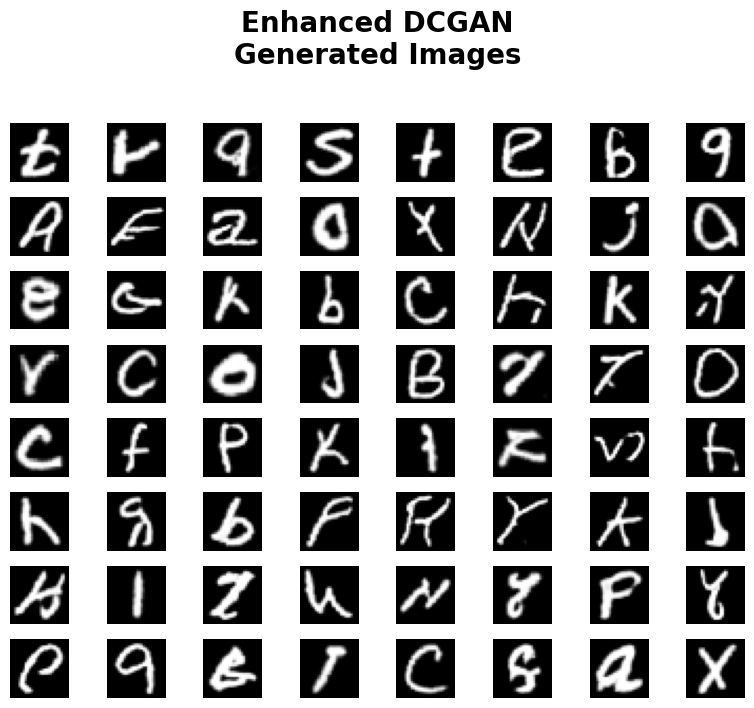

Time for epoch 100 is 25.4741952419281 sec


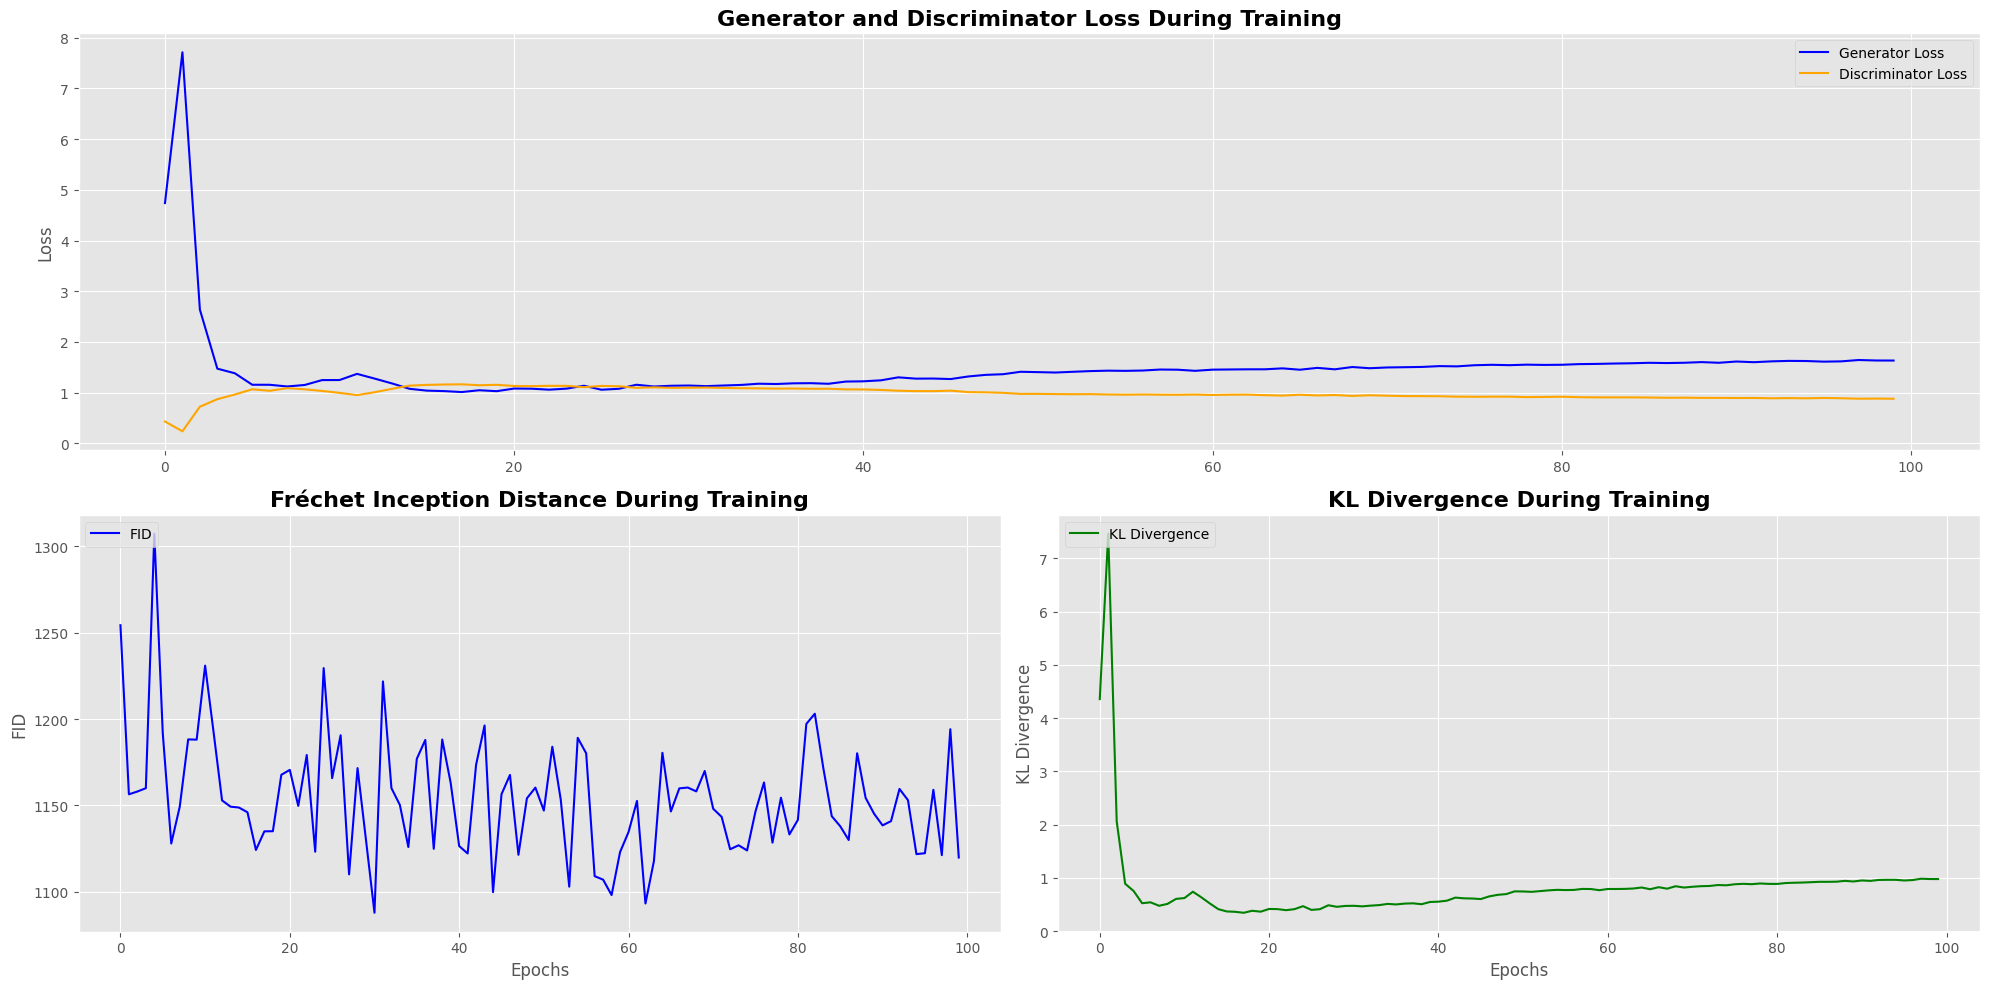

In [ ]:
enhanced_dcgan = Enhanced_DCGAN(epochs=100, num_examples_to_generate=64, noise_dim=100)
enhanced_dcgan.train(x_train)

<u>Observation:</u>

- Discriminator & Generator loss are diverging at 20th. `(Discriminator too strong)`
- KL Divergence had a big drop but starting to increase. `(Overfitting - less diverse outputs over time)`
- FID is fluctuating

<hr>

# **Conditional GAN** (**`cGAN`**)

A Conditional GAN (cGAN) is an extension of the traditional GAN (Generative Adversarial Network) that incorporates additional information, such as class labels, into both the generator and the discriminator. This conditioning allows cGANs to generate data that adheres to specific attributes or categories.

## **Key Components of cGAN**
<u>**Conditioning Mechanism**</u>
- Concatenation: The noise vector and condition vector are concatenated before being fed into the generator.
- Data and Condition Concatenation: The data and condition vector are concatenated before being fed into the discriminator.

<u>**Convolutional and Transposed Convolutional Layers**</u>
- Used in both the generator and discriminator to process the inputs.

In [ ]:
class CGAN:
    def __init__(self, noise_dim=100, num_examples_to_generate=26, epochs=50, batch_size=256, num_classes=26):
        self.noise_dim = noise_dim
        self.num_examples_to_generate = num_examples_to_generate
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
        self.classification_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_dim])
        self.seed_labels = tf.one_hot(np.arange(self.num_examples_to_generate), self.num_classes)
        self.epoch_images = []
        self.history = {
            'gen_loss_history': [],
            'disc_loss_history': [],
            'average_fid_history': [],
            'kl_divergence_history': [],
        }
        self.inception_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

    def make_generator_model(self):
        noise = Input(shape=(self.noise_dim,))
        label = Input(shape=(self.num_classes,))
        inputs = Concatenate()([noise, label])

        # Initial dense layer
        x = Dense(7*7*256, use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Reshape((7, 7, 256))(x)

        # Residual block function
        def residual_block(input_tensor, filter_count, stride_size):
            skip_connection = input_tensor

            x = Conv2DTranspose(filter_count, (3, 3), strides=stride_size, padding='same', use_bias=False)(input_tensor)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.2)(x)

            x = Conv2DTranspose(filter_count, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)

            if stride_size != (1, 1) or int(skip_connection.shape[-1]) != filter_count:
                skip_connection = Conv2DTranspose(filter_count, (1, 1), strides=stride_size, padding='same', use_bias=False)(skip_connection)

            x = Add()([x, skip_connection])
            x = LeakyReLU(alpha=0.2)(x)
            return x

        # Apply residual blocks
        x = residual_block(x, 128, (2, 2))
        x = residual_block(x, 64, (2, 2))

        # Final convolution layers
        x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

        model = Model([noise, label], x, name="Generator")
        return model

    def make_discriminator_model(self):
        image = Input(shape=(28, 28, 1))
        label = Input(shape=(self.num_classes,))

        label_embedding = Dense(28*28)(label)
        label_embedding = Reshape((28, 28, 1))(label_embedding)

        inputs = Concatenate(axis=-1)([image, label_embedding])

        def conv_block(input_tensor, filter_count, stride_size):
            x = Conv2D(filter_count, (3, 3), strides=stride_size, padding='same')(input_tensor)
            x = LeakyReLU(alpha=0.2)(x)
            x = Conv2D(filter_count, (3, 3), strides=(1, 1), padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            return x

        # Apply convolutional blocks
        x = conv_block(inputs, 64, (2, 2))
        x = Dropout(0.3)(x)

        x = conv_block(x, 128, (2, 2))
        x = Dropout(0.3)(x)

        x = conv_block(x, 256, (2, 2))
        x = Dropout(0.3)(x)

        # Global average pooling
        x = GlobalAveragePooling2D()(x)

        # Dense layers
        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.5)(x)

        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.5)(x)

        x = Dense(1, activation='sigmoid')(x)

        model = Model([image, label], x, name="Discriminator")
        return model

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def calculate_kl_divergence(self, p, q):
        # Ensure inputs are at least 2D
        p = tf.reshape(p, [-1, 1])
        q = tf.reshape(q, [-1, 1])

        # Clip values to avoid log(0)
        epsilon = 1e-10
        p = tf.clip_by_value(p, epsilon, 1.0)
        q = tf.clip_by_value(q, epsilon, 1.0)

        kl_div = tf.reduce_mean(p * (tf.math.log(p) - tf.math.log(q)))
        return kl_div

    @tf.function
    def train_step(self, images, labels):
        batch_size = tf.shape(images)[0]
        noise = tf.random.normal([batch_size, self.noise_dim])
        labels_one_hot = tf.one_hot(labels, self.num_classes)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator([noise, labels_one_hot], training=True)

            real_output = self.discriminator([images, labels_one_hot], training=True)
            fake_output = self.discriminator([generated_images, labels_one_hot], training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

            # Calculate KL divergence
            kl_div = self.calculate_kl_divergence(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return gen_loss, disc_loss, kl_div


    def generate_and_save_images(self, model, test_input, test_labels):
        predictions = model([test_input, test_labels], training=False)
        letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        num_classes = 26

        fig, ax = plt.subplots(2, 13, figsize=(26, 4))
        fig.suptitle(f"cGAN\nGenerated Images", fontsize=20, fontweight='bold', y=0.98)

        images = []
        for letter in range(num_classes):
            row = letter // 13
            col = letter % 13
            ax[row][col].set_title(letters[letter], fontsize=20, fontweight='bold', pad=10)
            ax[row][col].imshow(predictions[(letter+1)%26, :, :, 0] * 127.5 + 127.5, cmap='gray')
            ax[row][col].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])

        # Render the figure
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)

        plt.show()
        self.epoch_images.extend(images)

    def generate_GIF(self):
        imageio.mimsave("./CA2-Output/GAN-Generated_Images/Training/CGAN_Training.gif", self.epoch_images, duration=1)


    def calculate_fid(self, real_images, fake_images):

        real_images_resized = tf.image.resize(real_images, [75, 75])
        fake_images_resized = tf.image.resize(fake_images, [75, 75])

        # Ensure that the last dimension is explicitly set to 1 for grayscale images
        real_images_resized = tf.expand_dims(real_images_resized, axis=-1)
        fake_images_resized = tf.expand_dims(fake_images_resized, axis=-1)

        # Convert grayscale images to RGB
        real_images_rgb = tf.image.grayscale_to_rgb(real_images_resized)
        fake_images_rgb = tf.image.grayscale_to_rgb(fake_images_resized)

        # Ensure the shape is correct
        real_images_rgb_shaped = tf.reshape(real_images_rgb, [-1, 75, 75, 3])
        fake_images_rgb_shaped = tf.reshape(fake_images_rgb, [-1, 75, 75, 3])

        # Preprocess for InceptionV3
        real_images_rgb_processed = preprocess_input(real_images_rgb_shaped)
        fake_images_rgb_processed = preprocess_input(fake_images_rgb_shaped)

        real_features = self.inception_model(real_images_rgb_processed)
        fake_features = self.inception_model(fake_images_rgb_processed)

        # Calculate Fréchet Inception Distance
        mu_real = np.mean(real_features, axis=0)
        sigma_real = np.cov(real_features, rowvar=False)
        mu_fake = np.mean(fake_features, axis=0)
        sigma_fake = np.cov(fake_features, rowvar=False)
        fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(np.dot(sigma_real, sigma_fake)))

        return fid

    def plot_losses_fid_kld(self):
        fig = plt.figure(figsize=(20, 10))
        gs = GridSpec(2, 2, height_ratios=[1, 1])  # Create a GridSpec with two rows and two columns

        # Create the top subplot (row 0, spanning both columns)
        ax_top = fig.add_subplot(gs[0, :])
        ax_top.plot(self.history['gen_loss_history'], label='Generator Loss', color='blue')
        ax_top.plot(self.history['disc_loss_history'], label='Discriminator Loss', color='orange')
        ax_top.set_ylabel('Loss')
        ax_top.legend()
        ax_top.set_title('Generator and Discriminator Loss During Training', fontsize=16, fontweight='bold')

        # Create the bottom left subplot (row 1, column 0)
        ax_bottom_left = fig.add_subplot(gs[1, 0])
        ax_bottom_left.plot(self.history['average_fid_history'], label='FID', color='blue')
        ax_bottom_left.set_xlabel('Epochs')
        ax_bottom_left.set_ylabel('FID')
        ax_bottom_left.set_title('Fréchet Inception Distance During Training', fontsize=16, fontweight='bold')
        ax_bottom_left.legend(loc='upper left')

        # Create the bottom right subplot (row 1, column 1)
        ax_bottom_right = fig.add_subplot(gs[1, 1])
        ax_bottom_right.plot(self.history['kl_divergence_history'], label='KL Divergence', color='green')
        ax_bottom_right.set_xlabel('Epochs')
        ax_bottom_right.set_ylabel('KL Divergence')
        ax_bottom_right.set_title('KL Divergence During Training', fontsize=16, fontweight='bold')
        ax_bottom_right.legend(loc='upper left')

        plt.tight_layout()  # Adjust layout to prevent overlap of labels
        plt.show()

    def train(self, dataset):
        for epoch in range(self.epochs):
            start = time.time()
            gen_losses = []
            disc_losses = []
            kl_divs = []
            for image_batch, label_batch in tqdm(dataset):
                gen_loss, disc_loss, kl_div = self.train_step(image_batch, label_batch)
                gen_losses.append(gen_loss)
                disc_losses.append(disc_loss)
                kl_divs.append(kl_div)

            self.history['gen_loss_history'].append(np.mean(gen_losses))
            self.history['disc_loss_history'].append(np.mean(disc_losses))
            self.history['kl_divergence_history'].append(np.mean(kl_divs))

            display.clear_output(wait=True)
            self.generate_and_save_images(self.generator, self.seed, self.seed_labels)

            # Calculate FID and KID
            all_real_images = []
            all_fake_images = []
            for image_batch, label_batch in dataset.take(4):
                noise = tf.random.normal([tf.shape(image_batch)[0], self.noise_dim])
                labels_one_hot = tf.one_hot(label_batch, self.num_classes)
                generated_images = self.generator([noise, labels_one_hot], training=False)

                all_real_images.append(image_batch)
                # Squeeze the fake images to remove the single-channel dimension if present
                squeezed_generated_images = tf.squeeze(generated_images, axis=-1)
                all_fake_images.append(squeezed_generated_images)

            all_real_images = tf.concat(all_real_images, axis=0)
            all_fake_images = tf.concat(all_fake_images, axis=0)

            average_fid = self.calculate_fid(all_real_images, all_fake_images)
            self.history['average_fid_history'].append(average_fid)

            print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

        self.generate_GIF()
        self.plot_losses_fid_kld()

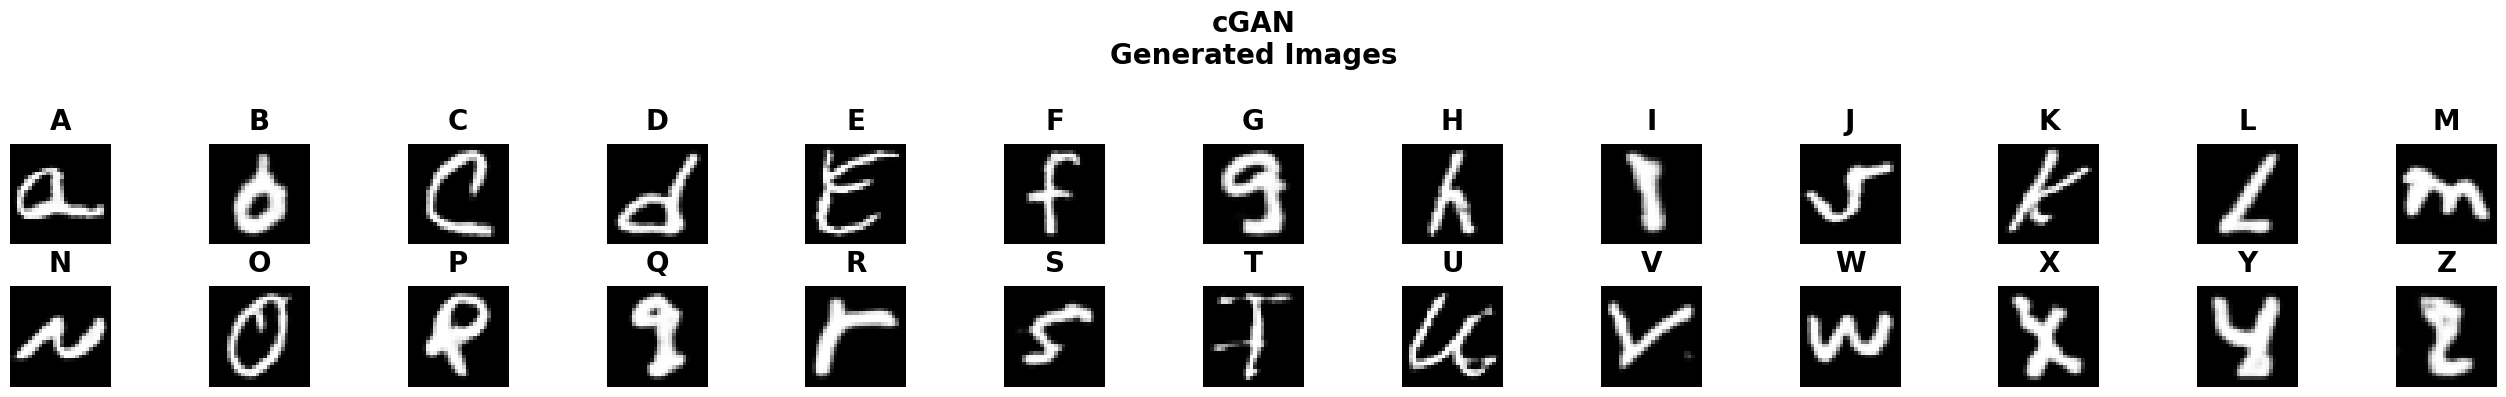

Time for epoch 100 is 20.426832675933838 sec


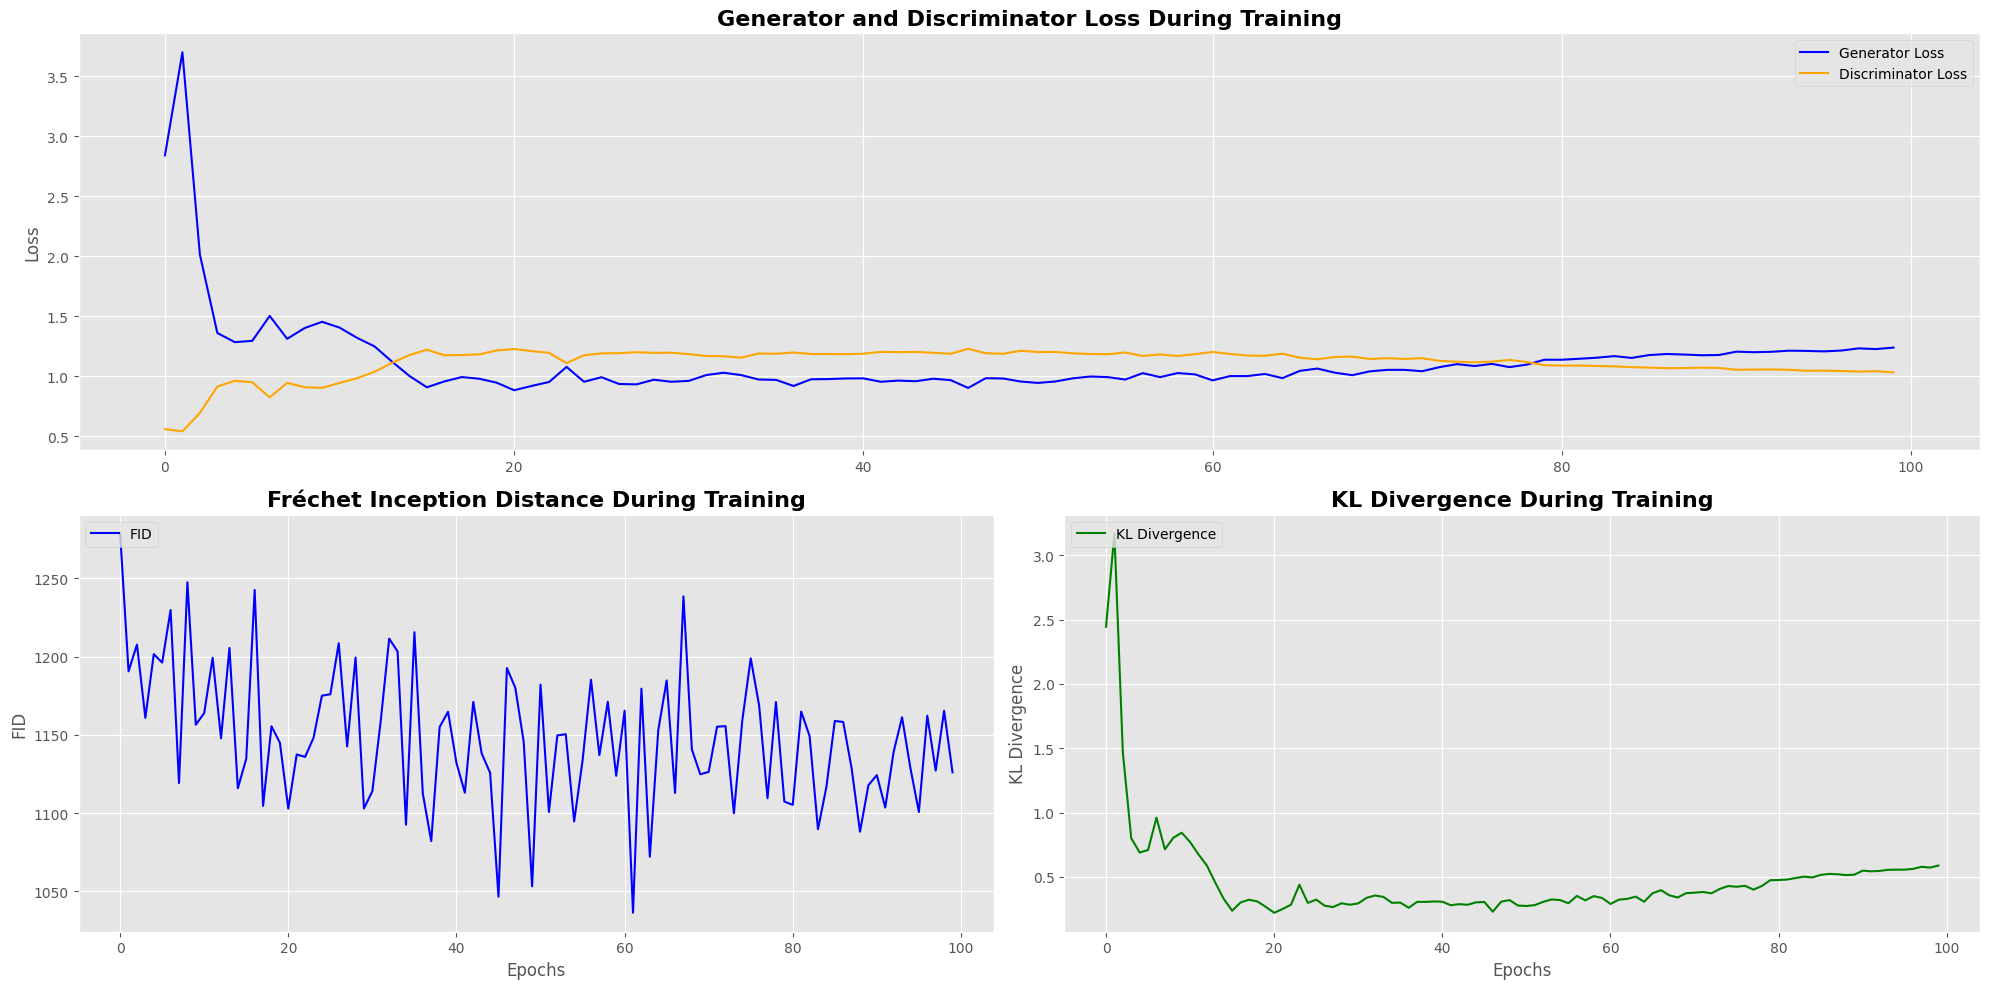

In [ ]:
cgan = CGAN(epochs=100, batch_size=BATCH_SIZE, num_classes=26)
cgan.train(dataset_train)

<u>Observation:</u>

- Both losses stabilize after initial fluctuations `(Training Well)`
- FID score fluctuating
- KL Divergence dropped, but started to slowly rise. `(Overfitted)`

<hr>

# **TripleGAN Model**

A TripleGAN is an extension of the traditional GAN (Generative Adversarial Network) framework, designed to improve semi-supervised learning tasks. It consists of three main components working together in a unified framework.

## **Key Components of TripleGAN**

<u>**Classifier (C)**</u>
- Performs the main classification task.
- Learns from both labeled and unlabelled data.

## **Unique Aspects of TripleGAN**

<u>**Three-Player Game**</u>
- G, C, and D engage in a three-way adversarial game.
- Each component has its own objective function.

<u>**Semi-Supervised Learning**</u>
- Effectively utilizes both labeled and unlabelled data.
- Improves classification performance with limited labeled data.

<u>**Consistency Regularization**</u>
- Enforces consistency between G and C.
- Helps in generating high-quality, class-consistent samples.

## **Data Flow in TripleGAN**

1. G generates fake samples from random noise.
2. C classifies both real and generated samples.
3. D discriminates between:
   - Real samples with ground truth labels
   - Real samples with labels assigned by C
   - Fake samples generated by G with corresponding labels

## **Training Process**

- Alternating optimization of G, C, and D.
- Balancing between adversarial loss and classification loss.
- Gradual improvement in both generation and classification tasks.

## **Advantages of TripleGAN**

1. Improved semi-supervised learning performance.
2. Better quality and diversity of generated samples.
3. Enhanced stability in training compared to traditional GANs.
4. Effective utilization of unlabelled data for classification tasks.

In [6]:
class TripleGAN:
    def __init__(self, noise_dim=100, num_examples_to_generate=26, epochs=50, batch_size=256, num_classes=26):
        self.noise_dim = noise_dim
        self.num_examples_to_generate = num_examples_to_generate
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy()
        self.classification_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.classifier = self.make_classifier_model()
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.classifier_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_dim])
        self.seed_labels = tf.one_hot(np.arange(self.num_examples_to_generate), self.num_classes)
        self.epoch_images = []
        self.history = {
            'gen_loss_history': [],
            'disc_loss_history': [],
            'class_loss_history': [],
            'average_fid_history': [],
            'kl_divergence_history': [],
            'classifier_accuracy': []
        }
        self.inception_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')

    def make_generator_model(self):
        noise = Input(shape=(self.noise_dim,))
        label = Input(shape=(self.num_classes,))
        inputs = Concatenate()([noise, label])

        x = Dense(7*7*256, use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Reshape((7, 7, 256))(x)

        def residual_block(input_tensor, filter_count, stride_size):
            skip_connection = input_tensor

            x = Conv2DTranspose(filter_count, (3, 3), strides=stride_size, padding='same', use_bias=False)(input_tensor)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.2)(x)

            x = Conv2DTranspose(filter_count, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)

            if stride_size != (1, 1) or int(skip_connection.shape[-1]) != filter_count:
                skip_connection = Conv2DTranspose(filter_count, (1, 1), strides=stride_size, padding='same', use_bias=False)(skip_connection)

            x = Add()([x, skip_connection])
            x = LeakyReLU(alpha=0.2)(x)
            return x

        x = residual_block(x, 128, (2, 2))
        x = residual_block(x, 64, (2, 2))

        x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

        model = Model([noise, label], x, name="Generator")
        return model

    def make_discriminator_model(self):
        image = Input(shape=(28, 28, 1))
        label = Input(shape=(self.num_classes,))

        label_embedding = Dense(28*28)(label)
        label_embedding = Reshape((28, 28, 1))(label_embedding)

        inputs = Concatenate(axis=-1)([image, label_embedding])

        def conv_block(input_tensor, filter_count, stride_size):
            x = Conv2D(filter_count, (3, 3), strides=stride_size, padding='same')(input_tensor)
            x = LeakyReLU(alpha=0.2)(x)
            x = Conv2D(filter_count, (3, 3), strides=(1, 1), padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            return x

        x = conv_block(inputs, 64, (2, 2))
        x = Dropout(0.3)(x)

        x = conv_block(x, 128, (2, 2))
        x = Dropout(0.3)(x)

        x = conv_block(x, 256, (2, 2))
        x = Dropout(0.3)(x)

        x = GlobalAveragePooling2D()(x)

        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.5)(x)

        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.5)(x)

        x = Dense(1, activation='sigmoid')(x)

        model = Model([image, label], x, name="Discriminator")
        return model

    def make_classifier_model(self):
        image = Input(shape=(28, 28, 1))

        x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(image)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)

        x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)

        x = Flatten()(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.5)(x)

        x = Dense(self.num_classes, activation='softmax')(x)

        model = Model(image, x, name="Classifier")
        return model

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def classifier_loss(self, true_labels, predicted_labels):
        return self.classification_loss(true_labels, predicted_labels)

    def calculate_kl_divergence(self, p, q):
        # Ensure inputs are at least 2D
        p = tf.reshape(p, [-1, 1])
        q = tf.reshape(q, [-1, 1])

        # Clip values to avoid log(0)
        epsilon = 1e-10
        p = tf.clip_by_value(p, epsilon, 1.0)
        q = tf.clip_by_value(q, epsilon, 1.0)

        kl_div = tf.reduce_mean(p * (tf.math.log(p) - tf.math.log(q)))
        return kl_div

    def evaluate_classifier(self, dataset):
        total_correct = 0
        total_samples = 0

        for images, labels in dataset:
            predicted_labels = self.classifier(images, training=False)
            predicted_labels = tf.argmax(predicted_labels, axis=1)
            total_correct += tf.reduce_sum(tf.cast(predicted_labels == labels, tf.int32))
            total_samples += images.shape[0]

        accuracy = total_correct / total_samples
        return accuracy.numpy()

    @tf.function
    def train_step(self, images, labels):
        batch_size = tf.shape(images)[0]
        noise = tf.random.normal([batch_size, self.noise_dim])
        labels_one_hot = tf.one_hot(labels, self.num_classes)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as class_tape:
            generated_images = self.generator([noise, labels_one_hot], training=True)

            real_output = self.discriminator([images, labels_one_hot], training=True)
            fake_output = self.discriminator([generated_images, labels_one_hot], training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

            real_class_output = self.classifier(images, training=True)
            fake_class_output = self.classifier(generated_images, training=True)

            # Convert labels to integers if they are one-hot encoded
            if labels_one_hot.shape[1] == self.num_classes:
                labels = tf.argmax(labels_one_hot, axis=1)

            class_loss = self.classifier_loss(labels, real_class_output) + self.classifier_loss(labels, fake_class_output)

            kl_div = self.calculate_kl_divergence(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        gradients_of_classifier = class_tape.gradient(class_loss, self.classifier.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        self.classifier_optimizer.apply_gradients(zip(gradients_of_classifier, self.classifier.trainable_variables))

        return gen_loss, disc_loss, class_loss, kl_div


    def generate_and_save_images(self, model, test_input, test_labels):
        predictions = model([test_input, test_labels], training=False)
        letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        num_classes = 26

        fig, ax = plt.subplots(2, 13, figsize=(26, 4))
        fig.suptitle(f"TripleGAN\nGenerated Images", fontsize=20, fontweight='bold', y=0.98)

        images = []
        for letter in range(num_classes):
            row = letter // 13
            col = letter % 13
            ax[row][col].set_title(letters[letter], fontsize=20, fontweight='bold', pad=10)
            ax[row][col].imshow(predictions[(letter+1)%26, :, :, 0] * 127.5 + 127.5, cmap='gray')
            ax[row][col].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)

        plt.show()
        self.epoch_images.extend(images)

    def generate_GIF(self):
        imageio.mimsave("./CA2-Output/GAN-Generated_Images/Training/TripleGAN_Training.gif", self.epoch_images, duration=1)

    def calculate_fid(self, real_images, fake_images):
        real_images_resized = tf.image.resize(real_images, [75, 75])
        fake_images_resized = tf.image.resize(fake_images, [75, 75])

        real_images_resized = tf.expand_dims(real_images_resized, axis=-1)
        fake_images_resized = tf.expand_dims(fake_images_resized, axis=-1)

        real_images_rgb = tf.image.grayscale_to_rgb(real_images_resized)
        fake_images_rgb = tf.image.grayscale_to_rgb(fake_images_resized)

        real_images_rgb_shaped = tf.reshape(real_images_rgb, [-1, 75, 75, 3])
        fake_images_rgb_shaped = tf.reshape(fake_images_rgb, [-1, 75, 75, 3])

        real_images_rgb_processed = preprocess_input(real_images_rgb_shaped)
        fake_images_rgb_processed = preprocess_input(fake_images_rgb_shaped)

        real_features = self.inception_model(real_images_rgb_processed)
        fake_features = self.inception_model(fake_images_rgb_processed)

        mu_real = np.mean(real_features, axis=0)
        sigma_real = np.cov(real_features, rowvar=False)
        mu_fake = np.mean(fake_features, axis=0)
        sigma_fake = np.cov(fake_features, rowvar=False)
        fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(np.dot(sigma_real, sigma_fake)))

        return fid

    def plot_losses_fid_kld(self):
        fig = plt.figure(figsize=(20, 15))
        gs = GridSpec(3, 2, height_ratios=[1, 1, 1])

        ax_top = fig.add_subplot(gs[0, :])
        ax_top.plot(self.history['gen_loss_history'], label='Generator Loss', color='blue')
        ax_top.plot(self.history['disc_loss_history'], label='Discriminator Loss', color='orange')
        ax_top.plot(self.history['class_loss_history'], label='Classifier Loss', color='green')
        ax_top.set_ylabel('Loss')
        ax_top.legend()
        ax_top.set_title('Generator & Discriminator & Classifier Loss During Training', fontsize=16, fontweight='bold')

        ax_middle = fig.add_subplot(gs[1, :])
        ax_middle.plot(self.history['classifier_accuracy'], label='Classifier Accuracy', color='green')
        ax_middle.set_ylabel('Accuracy')
        ax_middle.legend()
        ax_middle.set_title('Classifier Accuracy During Training', fontsize=16, fontweight='bold')

        ax_bottom_left = fig.add_subplot(gs[2, 0])
        ax_bottom_left.plot(self.history['average_fid_history'], label='FID', color='blue')
        ax_bottom_left.set_xlabel('Epochs')
        ax_bottom_left.set_ylabel('FID')
        ax_bottom_left.set_title('Fréchet Inception Distance', fontsize=16, fontweight='bold')
        ax_bottom_left.legend(loc='upper left')

        ax_bottom_right = fig.add_subplot(gs[2, 1])
        ax_bottom_right.plot(self.history['kl_divergence_history'], label='KL Divergence', color='red')
        ax_bottom_right.set_xlabel('Epochs')
        ax_bottom_right.set_ylabel('KL Divergence')
        ax_bottom_right.set_title('KL Divergence During Training', fontsize=16, fontweight='bold')
        ax_bottom_right.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

    def train(self, dataset):
        for epoch in range(self.epochs):
            start = time.time()
            gen_losses = []
            disc_losses = []
            class_losses = []
            kl_divs = []
            for image_batch, label_batch in tqdm(dataset):
                gen_loss, disc_loss, class_loss, kl_div = self.train_step(image_batch, label_batch)
                gen_losses.append(gen_loss)
                disc_losses.append(disc_loss)
                class_losses.append(class_loss)
                kl_divs.append(kl_div)

            self.history['gen_loss_history'].append(np.mean(gen_losses))
            self.history['disc_loss_history'].append(np.mean(disc_losses))
            self.history['class_loss_history'].append(np.mean(class_losses))
            self.history['kl_divergence_history'].append(np.mean(kl_divs))

            display.clear_output(wait=True)
            self.generate_and_save_images(self.generator, self.seed, self.seed_labels)

            # Calculate FID
            all_real_images = []
            all_fake_images = []
            for image_batch, label_batch in dataset.take(4):
                noise = tf.random.normal([tf.shape(image_batch)[0], self.noise_dim])
                labels_one_hot = tf.one_hot(label_batch, self.num_classes)
                generated_images = self.generator([noise, labels_one_hot], training=False)

                all_real_images.append(image_batch)
                squeezed_generated_images = tf.squeeze(generated_images, axis=-1)
                all_fake_images.append(squeezed_generated_images)

            all_real_images = tf.concat(all_real_images, axis=0)
            all_fake_images = tf.concat(all_fake_images, axis=0)

            average_fid = self.calculate_fid(all_real_images, all_fake_images)
            self.history['average_fid_history'].append(average_fid)

            accuracy = self.evaluate_classifier(dataset)
            self.history['classifier_accuracy'].append(accuracy)

            print(f'Time for epoch {epoch + 1} is {time.time() - start:.2f} sec')

        self.generate_GIF()
        self.plot_losses_fid_kld()

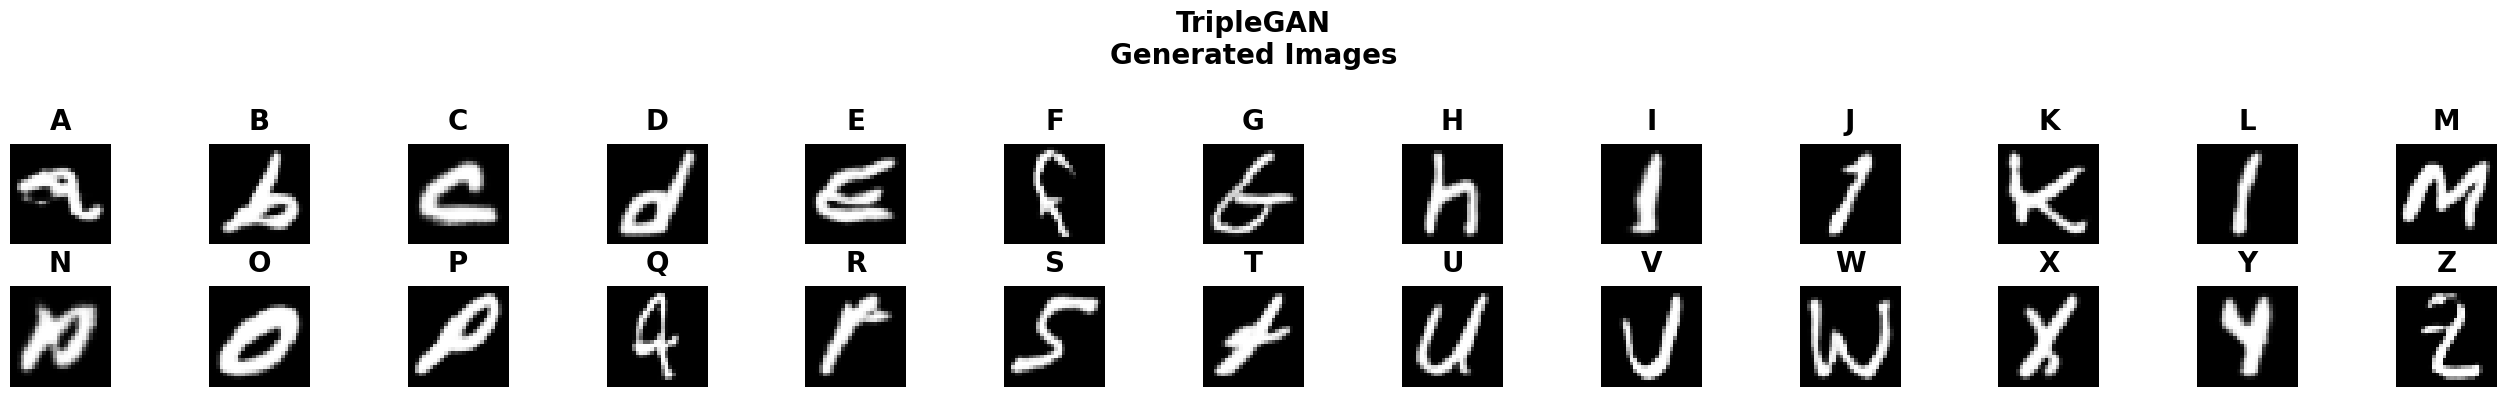

Time for epoch 100 is 45.60 sec


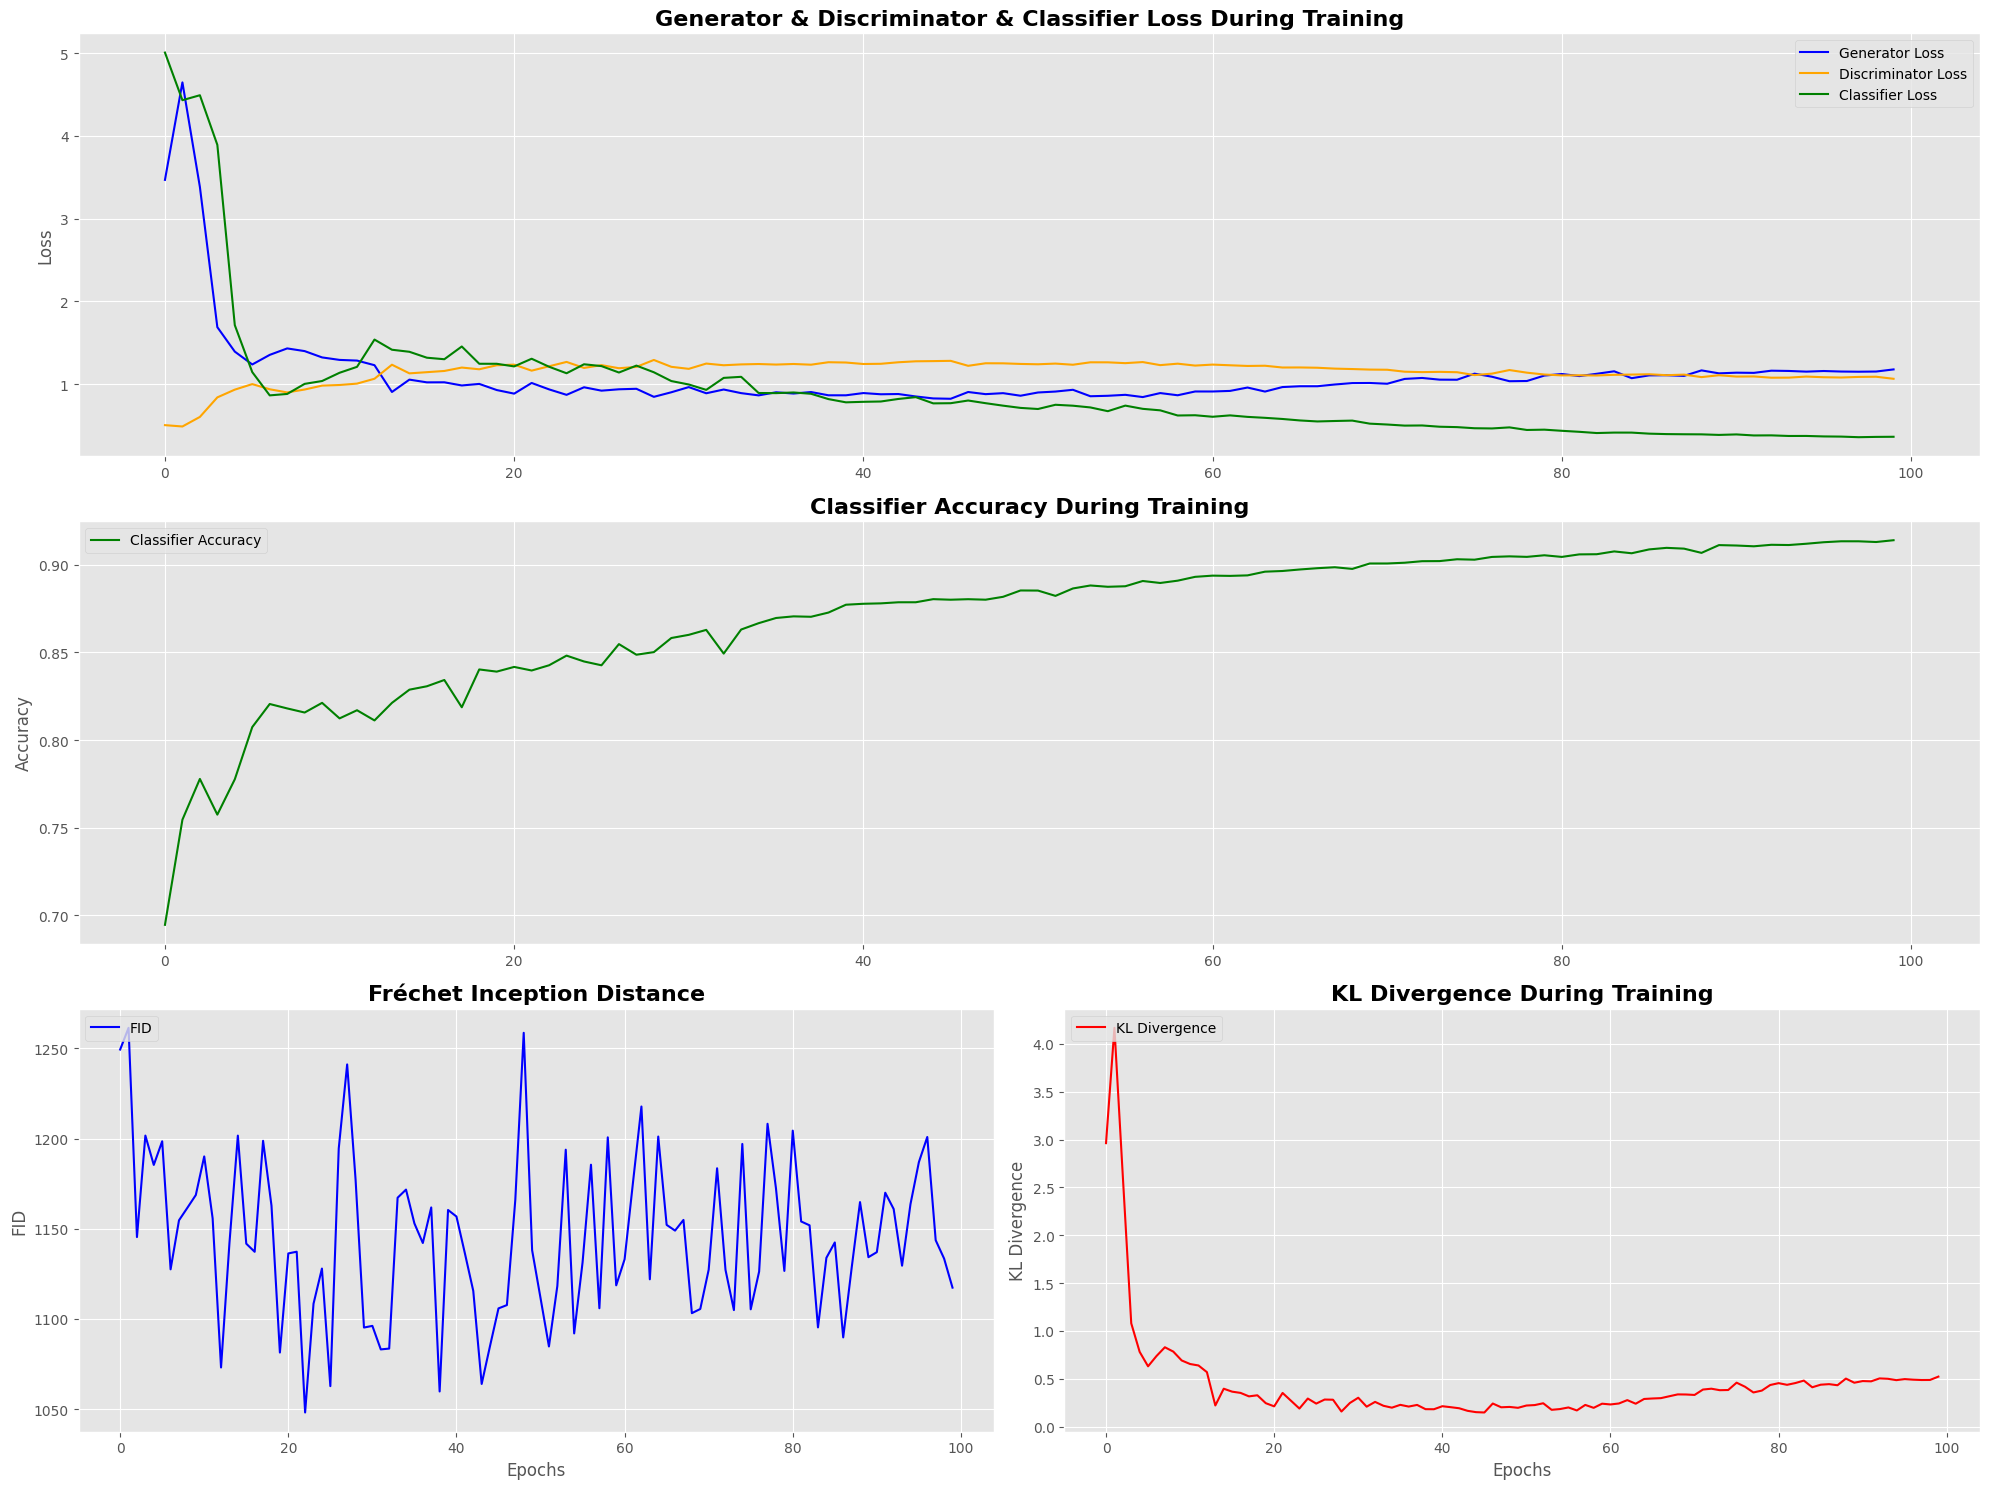

In [11]:
tripleGAN = TripleGAN(epochs=100, batch_size=BATCH_SIZE, num_classes=26)
tripleGAN.train(dataset_train)

<u>Observation:</u>

- `Initial Rapid Learning:` Both the generator and discriminator experience rapid loss reduction in the initial epochs & converged without diverging later on, indicating **Effective** early learning & **Consistancy**.
- `Classifier Improvement:` The classifier shows consistent improvement in accuracy, demonstrating that it is learning effectively from the generated and real images.
- `Stability Issues:` The FID score's fluctuations indicate some instability in the training process. This could be due to various factors such as learning rate, model architecture, or the nature of the dataset.
- `Convergence:` The steady decrease and stabilization of the KL divergence show that the model is converging well, despite the fluctuations in FID.

<hr>

# **Model Evaluation**

When evaluating GANs, several metrics can help assess the quality of generated samples. Here, we'll focus on two popular metrics:
- Fréchet Inception Distance (FID)
- Kullback-Leibler (KL) Divergence.
<hr>

## **Fréchet Inception Distance (FID)**
Fréchet Inception Distance (FID) measures the `distance between feature vectors` of real and generated images, extracted using a pre-trained Inception network. It compares the distributions of these feature vectors, calculated as multivariate Gaussian distributions, and computes the Fréchet distance between them.

**Formula**:<br>
Given two distributions $( p_r )$ (real) and $( p_g )$ (generated) with means $( mu_r )$ and $( mu_g )$ and covariances $( Σ_r )$ and $( Σ_g )$, the FID is computed as:

${FID} = |mu_r - mu_g|^2 + {Tr}(Σ_r + Σ_g - 2(Σ_r Σ_g)^{1/2})$

**<u>Pros</u>**
- **Effective for High-Dimensional Data**: FID is well-suited for evaluating high-dimensional data where pixel-wise comparisons are less effective.
- **Quantitative**: Provides a single scalar value that quantifies the similarity between the distributions of real and generated samples.
- **Widely Used**: A commonly accepted metric in the GAN community.

**<u>Cons</u>**
- **Dependence on Pre-Trained Networks**: The metric relies on a pre-trained Inception model, which may not be optimal for all types of data, including very low-dimensional datasets.
- **Less Informative for Simple Data**: FID might not provide meaningful feedback for very simple datasets, like 28x28 MNIST images.
<hr>

## **Kullback-Leibler (KL) Divergence**
Kullback-Leibler (KL) Divergence measures how one `probability distribution` diverges from a second, reference probability distribution. In the context of GANs, it is used to measure how the distribution of generated samples diverges from the distribution of real samples.

**Formula**
Given two probability distributions $( p )$ (real) and $( q )$ (generated), the KL divergence from $( q )$ to $( p )$ is:

$D_{KL}(p | q) = Σ_{x} p(x) \log\frac{p(x)}{q(x)}$

**<u>Pros</u>**
- **Direct Measurement**: Provides a direct way to quantify how different the generated distribution is from the real distribution.
- **Applicable to Various Data Types**: Can be applied to different types of data, including discrete and continuous distributions.

**<u>Cons</u>**
- **Non-Symmetric**: KL divergence is not symmetric, meaning $( D_{KL}(p | q) )$ is not necessarily equal to $( D_{KL}(q | p) )$. This can make interpretation more complex.
- **Requires Probability Distributions**: For discrete data, it requires accurate estimation of probability distributions, which might be difficult for high-dimensional or complex datasets.

**<u>Sources:</u>**<br>
`FID`: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/<br>
`KL_divergence`: https://towardsdatascience.com/understanding-kl-divergence-f3ddc8dff254
<hr>

In [13]:
labels = tf.one_hot(tf.cast(y, tf.int32), 26)
noise = tf.random.normal([26, 100])
noise_input = Input(shape=(100,))
label_input = Input(shape=(26,))

def generate_class_images(model, num_images_per_class):
    generated_images = []
    for class_label in range(26):
        noise = tf.random.normal([num_images_per_class, 100])
        labels = tf.one_hot(tf.ones((num_images_per_class,), dtype=tf.int32) * class_label, 26)
        images = model.generator([noise, labels], training=False)
        generated_images.append(images)
    return np.concatenate(generated_images)


def generate_images(generator, num_images, noise_dim):
    noise = tf.random.normal([num_images, noise_dim])
    generated_images = generator(noise, training=False)
    return generated_images

### **Baseline** `DCGAN`

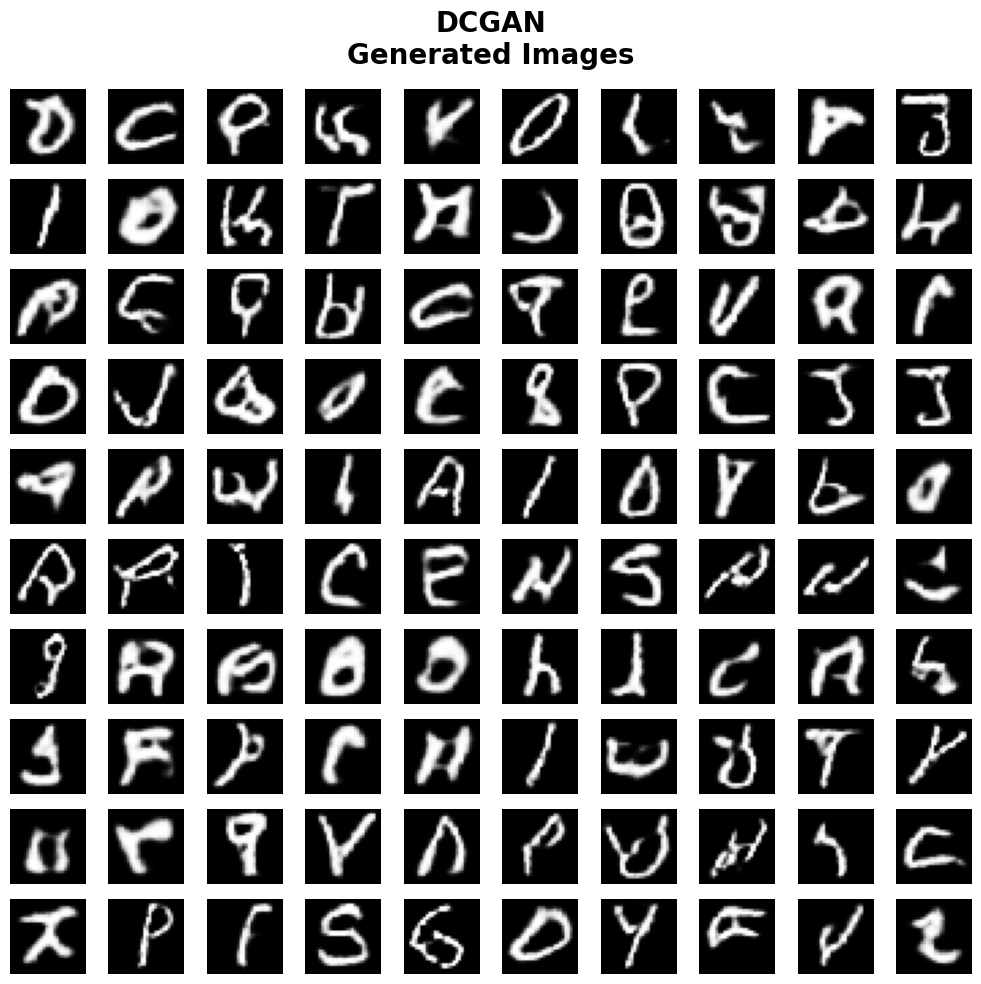

Final FID Score: (1151.2010363495885-1.0143414848089138e-06j)
Final KL Divergence Score: 0.29043588042259216


In [ ]:
noise_dim = 100  # Replace with your actual noise dimension
num_images = 100
generated_images = generate_images(dcgan.generator, num_images, noise_dim)

# Plot the generated images
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = generated_images[i].numpy()
    img = (img + 1) * 127.5
    ax.imshow(img[:, :, 0], cmap='gray')
    ax.axis('off')

plt.suptitle("DCGAN\nGenerated Images", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print(f"Final FID Score: {dcgan.history['average_fid_history'][-1]}")
print(f"Final KL Divergence Score: {dcgan.history['kl_divergence_history'][-1]}")

### **Enhanced DCGAN**

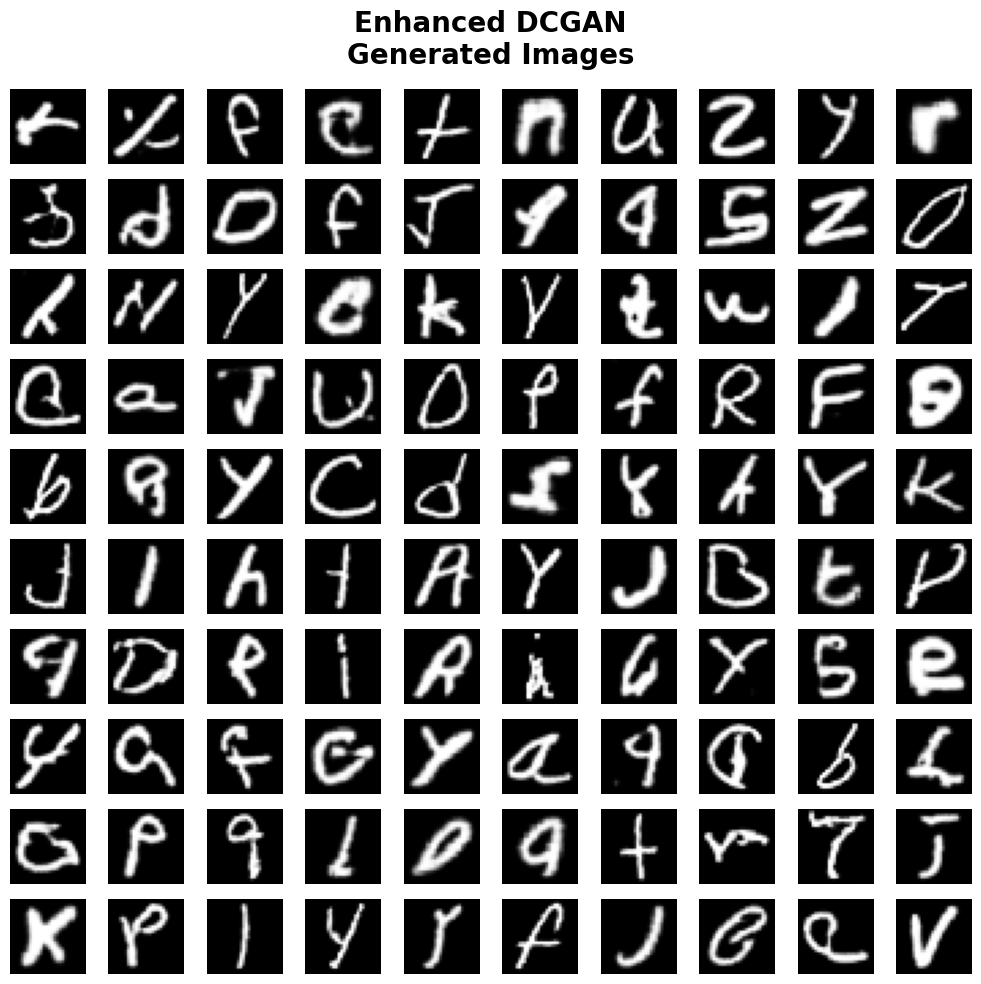

Final FID Score: (1119.8442485367116-1.432761950162636e-06j)
Final KL Divergence Score: 0.9759941697120667


In [ ]:
noise_dim = 100  # Replace with your actual noise dimension
num_images = 100
generated_images = generate_images(enhanced_dcgan.generator, num_images, noise_dim)

# Plot the generated images
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = generated_images[i].numpy()
    img = (img + 1) * 127.5
    ax.imshow(img[:, :, 0], cmap='gray')
    ax.axis('off')

plt.suptitle("Enhanced DCGAN\nGenerated Images", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print(f"Final FID Score: {enhanced_dcgan.history['average_fid_history'][-1]}")
print(f"Final KL Divergence Score: {enhanced_dcgan.history['kl_divergence_history'][-1]}")

### **Conditional GAN**

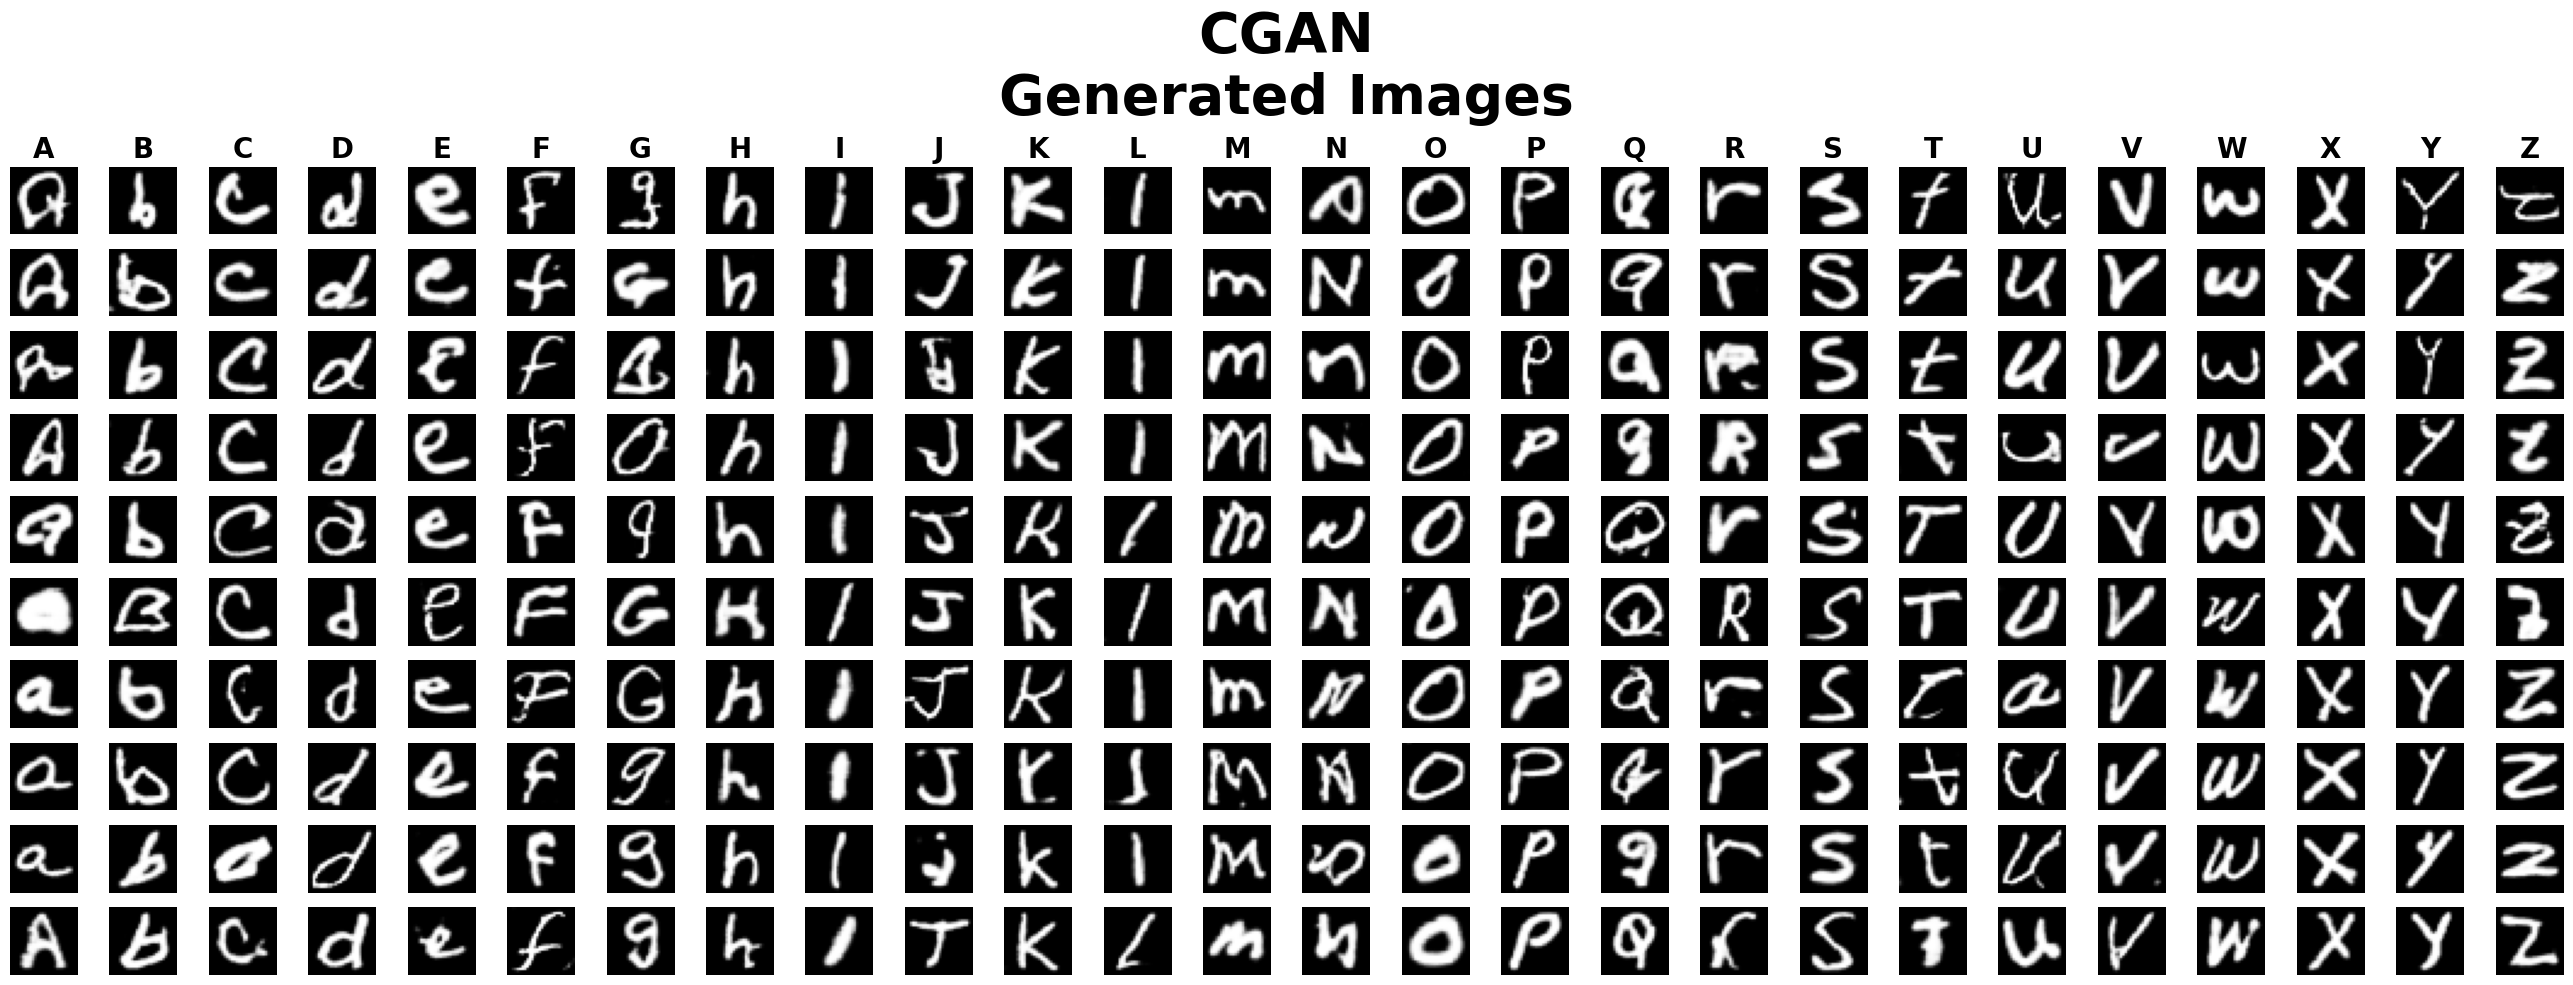

Final FID Score: (1126.0581244741397-1.2490973026436675e-06j)
Final KL Divergence Score: 0.5879080295562744


In [ ]:
# Generate images
num_images_per_class = 10
generated_images = generate_class_images(cgan, num_images_per_class)

# Plot the generated images
num_classes = 26
fig, ax = plt.subplots(num_images_per_class, num_classes, figsize=(26, 10))
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

for class_idx in range(num_classes):
    for row in range(num_images_per_class):
        img_idx = ((class_idx + 1) % num_classes) * num_images_per_class + row
        ax[row][class_idx].imshow(generated_images[img_idx, :, :, 0], cmap='gray')
        ax[row][class_idx].axis('off')
    ax[0][class_idx].set_title(letters[class_idx], fontsize=20, fontweight='bold')

plt.suptitle(f"CGAN\nGenerated Images", fontsize=40, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Final FID Score: {cgan.history['average_fid_history'][-1]}")
print(f"Final KL Divergence Score: {cgan.history['kl_divergence_history'][-1]}")

### **TripleGAN**

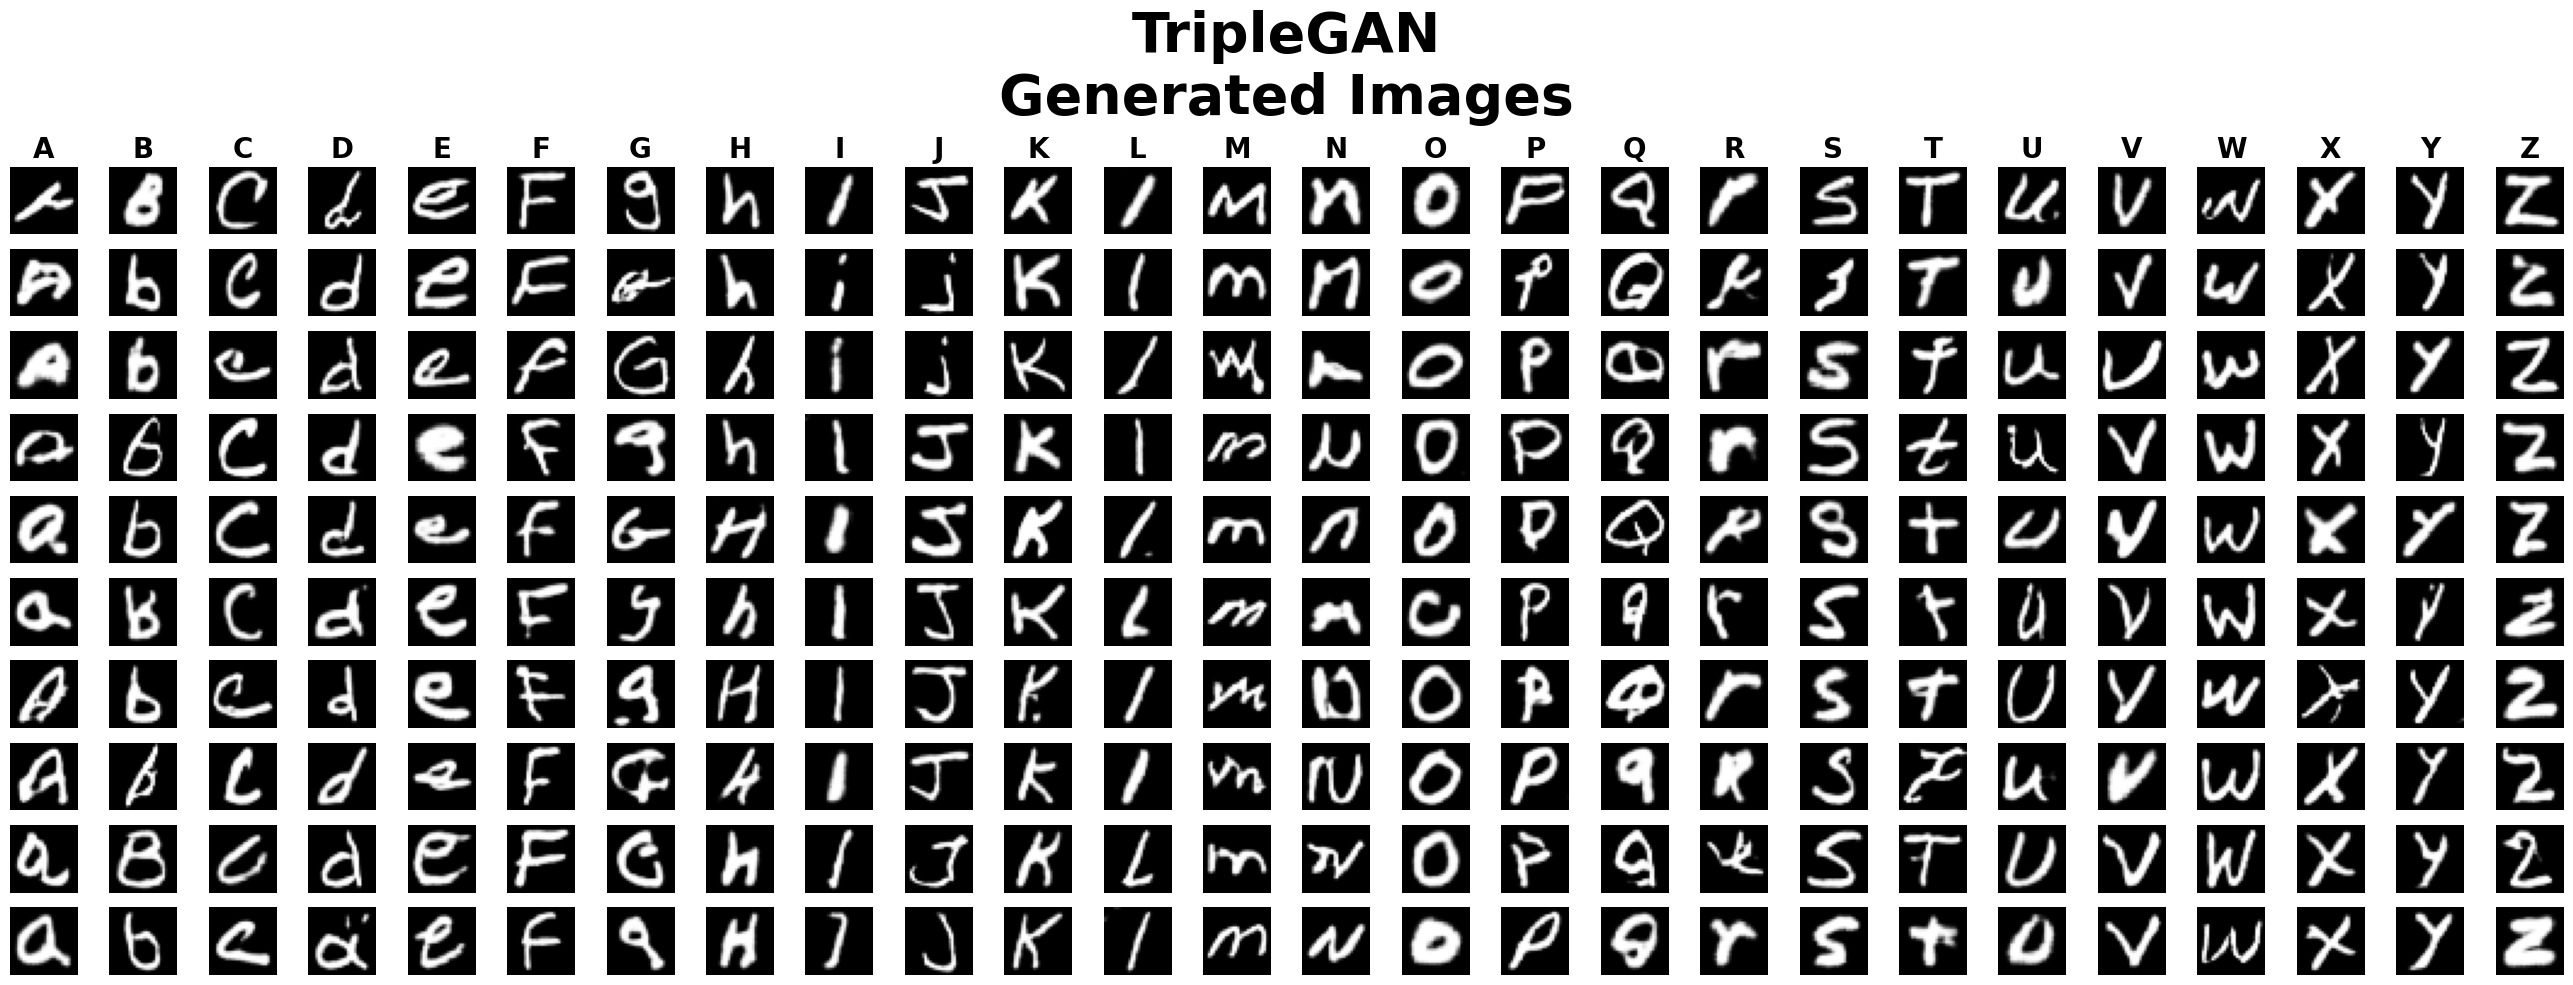

Final FID Score: (1117.3147484373017-1.1820227034145487e-06j)
Final KL Divergence Score: 0.5223722457885742


In [14]:
# Generate images
num_images_per_class = 10
generated_images = generate_class_images(tripleGAN, num_images_per_class)

# Plot the generated images
num_classes = 26
fig, ax = plt.subplots(num_images_per_class, num_classes, figsize=(26, 10))
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

for class_idx in range(num_classes):
    for row in range(num_images_per_class):
        img_idx = ((class_idx + 1) % num_classes) * num_images_per_class + row
        ax[row][class_idx].imshow(generated_images[img_idx, :, :, 0], cmap='gray')
        ax[row][class_idx].axis('off')
    ax[0][class_idx].set_title(letters[class_idx], fontsize=20, fontweight='bold')

plt.suptitle(f"TripleGAN\nGenerated Images", fontsize=40, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Final FID Score: {tripleGAN.history['average_fid_history'][-1]}")
print(f"Final KL Divergence Score: {tripleGAN.history['kl_divergence_history'][-1]}")

We **won't** be using Fréchet inception distance (FID) to evalute our best model. This is because the Inception Model is trained on the **ImageNet**

**ImageNet vs. MNIST:**<br>
- `ImageNet:` Consists of high-resolution, color images of various objects with significant variability in background, orientation, and scale.
- `MNIST:` Contains low-resolution, grayscale images of handwritten digits (0-9 or A-Z), which are much simpler and less varied compared to ImageNet images.

**Domain Mismatch:**
- `Feature Representation:` Features learned by the Inception model on ImageNet are unlikely to be relevant for MNIST data, leading to poor evaluation performance.
- `Misleading Results:` Using Inception metrics for MNIST can yield misleading results as the model may not capture the nuances of digit images, failing to provide meaningful insights into the performance of MNIST models.

Hence, we will be choosing our best model by evaluating their Final KL Divergence Score.

In [ ]:
model_evaluation = {
    "Model Type": ["DCGAN", "Enhanced DCGAN", "cGAN", "TripleGAN"],
    "Final FID": [model.history['average_fid_history'][-1] for model in [dcgan, enhanced_dcgan, cgan, tripleGAN]],
    "Final KL Divergence": [model.history['kl_divergence_history'][-1] for model in [dcgan, enhanced_dcgan, cgan, tripleGAN]]
}

In [9]:
def highlight_min(dataframe):
    min_kl_index = dataframe["Final KL Divergence"].idxmin()
    return pd.DataFrame([['background-color: yellow' if i == min_kl_index else '' for i in range(len(dataframe))]], index=[''])

model_evaluation = pd.DataFrame(model_evaluation)
styled_df = model_evaluation.style.apply(highlight_min, axis=0)
styled_df = model_evaluation.style.apply(lambda x: ['background-color: green' if x.name == model_evaluation["Final KL Divergence"].idxmin() else '' for _ in x], axis=1)
styled_df

Although DCGAN has the lowest KL Divergence Score, our objective is to generate 10 images of 26 letters in the alphabet. 

In order to do it we need to use `cGAN` or `TripleGAN`, where we can generate images from the labels.

Hence, we will be using <u>**`TripleGAN` as our best model**</u> as it has the **lowest** KL Divergence Score

<hr>

# **Model Improvement**
- SpectralNormalization
- Feature Matching

<hr>

## **Spectral Normalization**

Spectral Normalization (SN) is a regularization technique used to stabilize the training of deep neural networks, particularly in the context of Generative Adversarial Networks (GANs). It was introduced to address issues related to the Lipschitz continuity of the model’s function, which is critical for the convergence and stability of GANs. Spectral Normalization controls the spectral norm of weight matrices to ensure stable training dynamics.

In deep learning, especially in GANs, the weight matrices of neural networks can have very large spectral norms. This can lead to instability in training due to excessively large gradients or erratic changes in the model's outputs. Spectral Normalization addresses this by normalizing the weight matrices to control their spectral norms, thus enforcing a form of Lipschitz constraint on the model’s function.

1. **Spectral Norm Definition**:
   - The spectral norm of a matrix is the largest singular value of the matrix. For a weight matrix $ W $, its spectral norm $ \sigma(W) $ is defined as:
     $
     \sigma(W) = \max_{x \neq 0} \frac{\|W x\|_2}{\|x\|_2}
     $
   where $ \| \cdot \|_2 $ denotes the L2 norm.

2. **Normalization Process**:
   - Spectral Normalization involves dividing the weight matrix $ W $ by its spectral norm to ensure that the normalized weight matrix $ \hat{W} $ has a spectral norm of 1:
     $
     \hat{W} = \frac{W}{\sigma(W)}
     $
   - This normalization is applied to each weight matrix in the network to ensure that the spectral norm is bounded.

3. **Implementation Details**:
   - **Power Iteration**: To compute the spectral norm efficiently, Spectral Normalization uses a power iteration method to approximate the largest singular value of the weight matrix.
   - **Training**: Spectral Normalization is applied during both training and inference to maintain stability throughout the model's operation.

### **Benefits**

- **Improved Stability**: By controlling the spectral norm, Spectral Normalization helps in stabilizing the training of deep networks and prevents issues related to large gradients or unstable learning dynamics.
- **Better Convergence**: It improves convergence properties of GANs and other neural networks by ensuring that the model’s function is more well-behaved.
- **Effective in GANs**: Spectral Normalization has been shown to be particularly effective in GANs, where it helps to stabilize the training of the discriminator and the generator.

In [7]:
class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, iteration=1, eps=1e-12, training=True, **kwargs):
        self.iteration = iteration
        self.eps = eps
        self.do_power_iteration = training
        if not isinstance(layer, tf.keras.layers.Layer):
            raise ValueError(
                'Please initialize `TimeDistributed` layer with a '
                '`Layer` instance. You passed: {input}'.format(input=layer))
        super(SpectralNormalization, self).__init__(layer, **kwargs)

    def build(self, input_shape):
        self.layer.build(input_shape)

        self.w = self.layer.kernel
        self.w_shape = self.w.shape.as_list()

        self.u = self.add_weight(
            shape=(1, self.w_shape[-1]),
            initializer=tf.initializers.TruncatedNormal(stddev=0.02),
            trainable=False,
            name='sn_u',
            dtype=tf.float32)

        super(SpectralNormalization, self).build()

    def call(self, inputs):
        self._compute_weights()
        output = self.layer(inputs)
        return output

    def _compute_weights(self):
        w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])
        u_hat = self.u
        v_hat = None

        if self.do_power_iteration:
            for _ in range(self.iteration):
                v_ = tf.matmul(u_hat, tf.transpose(w_reshaped))
                v_hat = v_ / (tf.reduce_sum(v_**2)**0.5 + self.eps)

                u_ = tf.matmul(v_hat, w_reshaped)
                u_hat = u_ / (tf.reduce_sum(u_**2)**0.5 + self.eps)

        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
        self.u.assign(u_hat)
        self.layer.kernel.assign(self.w / sigma)

In [121]:
class ImprovedArchitecture:
    def __init__(self, noise_dim, num_examples_to_generate, epochs, batch_size, num_classes, hidden_size, dropout_rate, generator_strides, learning_rate=1e-4, num_layers=2):
        self.noise_dim = noise_dim
        self.num_examples_to_generate = num_examples_to_generate
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.generator_strides = generator_strides
        self.normalization = BatchNormalization
        self.activation = lambda: LeakyReLU(alpha=0.2)
        self.dropout = Dropout

        self.cross_entropy = BinaryCrossentropy()
        self.classification_loss = SparseCategoricalCrossentropy(from_logits=False)
        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.classifier = self.make_classifier_model()
        
        self.cross_entropy = BinaryCrossentropy()
        self.classification_loss = SparseCategoricalCrossentropy(from_logits=False)
        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.classifier = self.make_classifier_model()
        self.generator_optimizer = Adam(self.learning_rate)
        self.discriminator_optimizer = Adam(self.learning_rate)
        self.classifier_optimizer = Adam(self.learning_rate)
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_dim])
        self.seed_labels = tf.one_hot(np.arange(self.num_examples_to_generate), self.num_classes)
        self.epoch_images = []
        self.Final_KL_Divergence = float('inf')
        self.KLD_History = {}
        self.dropout_rate = 0.3
        self.leaky_alpha = 0.2

    def make_generator_model(self):
        noise = Input(shape=(self.noise_dim,))
        label = Input(shape=(self.num_classes,))
        inputs = Concatenate()([noise, label])

        x = Dense(7*7*256, use_bias=False)(inputs)
        x = self.normalization()(x)
        x = self.activation()(x)
        x = Reshape((7, 7, 256))(x)

        def residual_block(input_tensor, filter_count, stride_size):
            skip_connection = input_tensor

            x = Conv2DTranspose(filter_count, (3, 3), strides=stride_size, padding='same', use_bias=False)(input_tensor)
            x = self.normalization()(x)
            x = self.activation()(x)
            x = self.dropout(self.dropout_rate)(x)

            x = Conv2DTranspose(filter_count, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
            x = self.normalization()(x)

            if stride_size != (1, 1) or int(skip_connection.shape[-1]) != filter_count:
                skip_connection = Conv2DTranspose(filter_count, (1, 1), strides=stride_size, padding='same', use_bias=False)(skip_connection)

            x = Add()([x, skip_connection])
            x = self.activation()(x)
            return x

        # Upsample to 14x14
        x = residual_block(x, self.hidden_size, (2, 2))
        
        # Upsample to 28x28
        x = residual_block(x, self.hidden_size // 2, (2, 2))

        x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
        x = self.normalization()(x)
        x = self.activation()(x)

        x = Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

        model = Model([noise, label], x, name="Generator")
        return model

    def make_discriminator_model(self):
        image = Input(shape=(28, 28, 1))
        label = Input(shape=(self.num_classes,))

        label_embedding = SpectralNormalization(Dense(28*28))(label)
        label_embedding = Reshape((28, 28, 1))(label_embedding)

        inputs = Concatenate(axis=-1)([image, label_embedding])

        def conv_block(input_tensor, filter_count, stride_size):
            x = SpectralNormalization(Conv2D(filter_count, (3, 3), strides=stride_size, padding='same'))(input_tensor)
            x = LeakyReLU(alpha=0.2)(x)
            x = SpectralNormalization(Conv2D(filter_count, (3, 3), strides=(1, 1), padding='same'))(x)
            x = LeakyReLU(alpha=0.2)(x)
            return x

        x = inputs
        for _ in range(self.num_layers):
            x = conv_block(x, self.hidden_size, (2, 2))
            x = Dropout(self.dropout_rate)(x)

        x = GlobalAveragePooling2D()(x)

        x = SpectralNormalization(Dense(512))(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(self.dropout_rate)(x)

        x = SpectralNormalization(Dense(256))(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(self.dropout_rate)(x)

        x = SpectralNormalization(Dense(1, activation='sigmoid'))(x)

        model = Model([image, label], x, name="Discriminator")
        return model

    def make_classifier_model(self):
        image = Input(shape=(28, 28, 1))

        x = image
        for i in range(self.num_layers):
            x = SpectralNormalization(Conv2D(self.hidden_size * (2**i), (3, 3), strides=(2, 2), padding='same'))(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = Dropout(self.dropout_rate)(x)

        x = Flatten()(x)
        x = SpectralNormalization(Dense(256))(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(self.dropout_rate)(x)

        x = SpectralNormalization(Dense(self.num_classes, activation='softmax'))(x)

        model = Model(image, x, name="Classifier")
        return model

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def classifier_loss(self, true_labels, predicted_labels):
        return self.classification_loss(true_labels, predicted_labels)

    def calculate_kl_divergence(self, p, q):
        # Ensure inputs are at least 2D
        p = tf.reshape(p, [-1, 1])
        q = tf.reshape(q, [-1, 1])

        # Clip values to avoid log(0)
        epsilon = 1e-10
        p = tf.clip_by_value(p, epsilon, 1.0)
        q = tf.clip_by_value(q, epsilon, 1.0)

        # Normalize to ensure they sum to 1
        p = p / tf.reduce_sum(p)
        q = q / tf.reduce_sum(q)

        # Calculate KL divergence
        kl_div = tf.reduce_sum(p * (tf.math.log(p) - tf.math.log(q)))
        return kl_div


    @tf.function
    def train_step(self, images, labels):
        batch_size = tf.shape(images)[0]
        noise = tf.random.normal([batch_size, self.noise_dim])
        labels_one_hot = tf.one_hot(labels, self.num_classes)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as class_tape:
            generated_images = self.generator([noise, labels_one_hot], training=True)

            real_output = self.discriminator([images, labels_one_hot], training=True)
            fake_output = self.discriminator([generated_images, labels_one_hot], training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

            real_class_output = self.classifier(images, training=True)
            fake_class_output = self.classifier(generated_images, training=True)

            # Convert labels to integers if they are one-hot encoded
            if labels_one_hot.shape[1] == self.num_classes:
                labels = tf.argmax(labels_one_hot, axis=1)

            class_loss = self.classifier_loss(labels, real_class_output) + self.classifier_loss(labels, fake_class_output)

            kl_div = self.calculate_kl_divergence(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        gradients_of_classifier = class_tape.gradient(class_loss, self.classifier.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        self.classifier_optimizer.apply_gradients(zip(gradients_of_classifier, self.classifier.trainable_variables))

        return kl_div


    def generate_and_save_images(self, model, test_input, test_labels, model_count):
        predictions = model([test_input, test_labels], training=False)
        letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        num_classes = 26

        fig, ax = plt.subplots(2, 13, figsize=(26, 4))
        fig.suptitle(f"BestModel {model_count}\nGenerated Images", fontsize=20, fontweight='bold', y=0.98)

        images = []
        for letter in range(num_classes):
            row = letter // 13
            col = letter % 13
            ax[row][col].set_title(letters[letter], fontsize=20, fontweight='bold', pad=10)
            ax[row][col].imshow(predictions[letter, :, :, 0] * 127.5 + 127.5, cmap='gray')
            ax[row][col].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)

        plt.show()
        self.epoch_images.extend(images)

    def generate_GIF(self, model_count):
        imageio.mimsave(f"./CA2-Output/GAN-Generated_Images/Training/BestArchitecture{model_count}.gif", self.epoch_images, duration=1)

    def save_weights(self, model_count):
        # Create directories if they don't exist
        os.makedirs(f'model_weights/model_{model_count}', exist_ok=True)
        
        # Save generator weights
        generator_path = f'model_weights/model_{model_count}/generator_model_{model_count}.h5'
        self.generator.save_weights(generator_path)

        # Save discriminator weights
        discriminator_path = f'model_weights/model_{model_count}/discriminator_model_{model_count}.h5'
        self.discriminator.save_weights(discriminator_path)

        # If you have a separate classifier, save its weights too
        if hasattr(self, 'classifier'):
            classifier_path = f'model_weights/model_{model_count}/classifier_model_{model_count}.h5'
            self.classifier.save_weights(classifier_path)

    def train(self, dataset, model_count):
        for epoch in range(self.epochs):
            start = time.time()

            kl_divs = []
            for image_batch, label_batch in tqdm(dataset):
                kl_div = self.train_step(image_batch, label_batch)
                kl_divs.append(kl_div)

            display.clear_output(wait=True)
            self.generate_and_save_images(self.generator, self.seed, self.seed_labels, model_count)
            print(f'Model {model_count} >> Time for epoch {epoch + 1} is {time.time() - start:.2f} sec')

        self.Final_KL_Divergence = np.mean(kl_divs)
        self.KLD_History[model_count] = np.mean(kl_divs)
        self.generate_GIF(model_count)

        # Save weights at the end of training
        self.save_weights(model_count)

In [122]:
def random_search_hyperparameters(dataset, num_trials, epochs, batch_size, num_classes, noise_dim, num_examples_to_generate):
    param_grid = {
        'hidden_size': [64, 128, 256],
        'dropout_rate': [0.3, 0.4, 0.5],
        'generator_strides': [(2, 2), (1, 1)]
    }

    best_score = float('inf')
    best_params = None
    results = []

    for model_count in range(num_trials):
        current_params = {k: random.choice(v) for k, v in param_grid.items()}
        
        # Create a new ImprovedArchitecture instance with the current parameters
        improvedArchitecture = ImprovedArchitecture(
            noise_dim=noise_dim,
            num_examples_to_generate=num_examples_to_generate,
            epochs=epochs,
            batch_size=batch_size,
            num_classes=num_classes,
            **current_params
        )

        # Train the model
        improvedArchitecture.train(dataset, model_count+1)

        score = improvedArchitecture.Final_KL_Divergence

        results.append((current_params, score))
        
        if score < best_score:
            best_score = score
            best_params = current_params

    return results, best_params

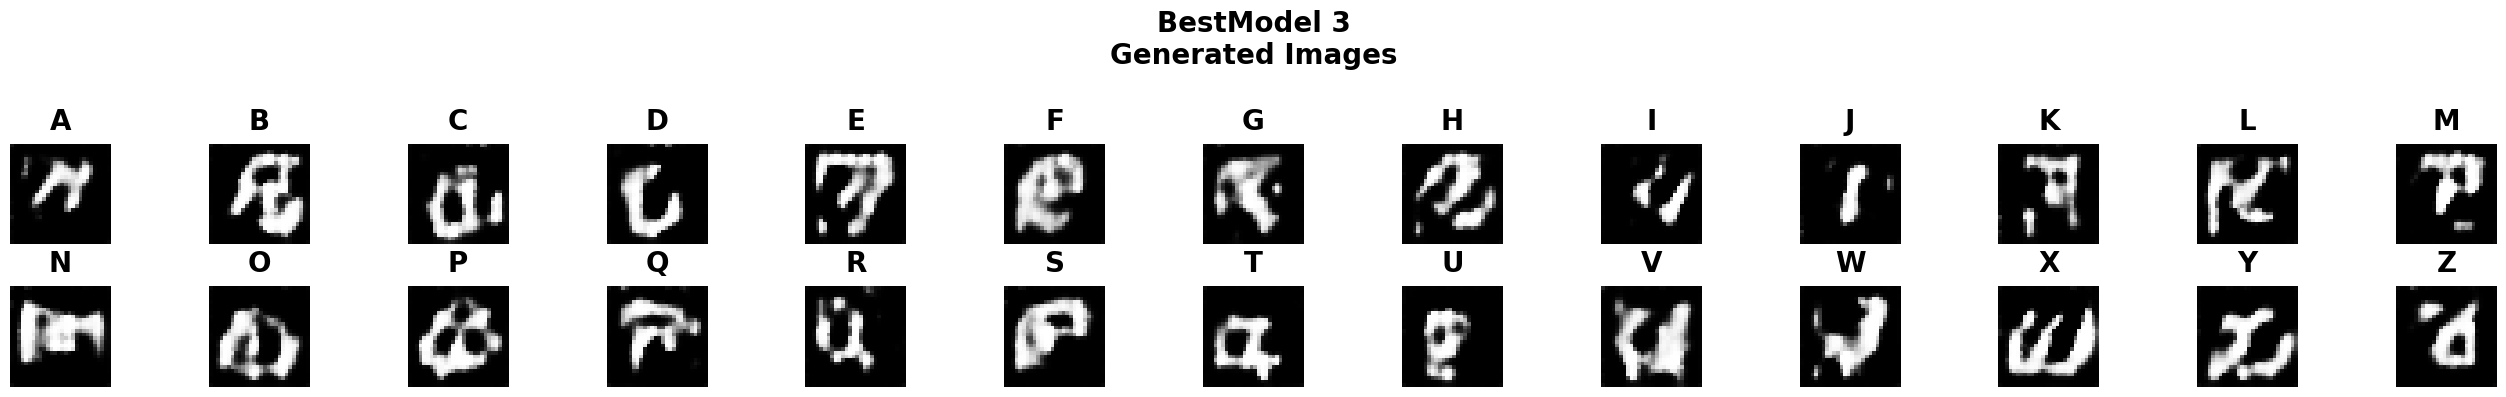

Model 3 >> Time for epoch 50 is 47.09 sec


In [124]:
results, best_params = random_search_hyperparameters(
    dataset_train, 
    num_trials=3, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    num_classes=26, 
    noise_dim=100, 
    num_examples_to_generate=26
)

**<u>Observation</u>**:
- Several images show incomplete or ambiguous forms that do not clearly represent any specific letter or number. This indicates that the generator may not have fully learned the underlying structure of the dataset it was trained on.

- **Spectral Normalization Didn't Help:**
    - `Simple Dataset:` our dataset consists of simple alphabet letters, the discriminator might easily distinguish between real and fake images without needing spectral normalization. Spectral normalization is particularly useful for more complex datasets where the discriminator might become too powerful. For simple datasets, it might hinder the generator's ability to improve, as you noted.

    - `Focus on Obvious Errors:` Spectral normalization helps by stabilizing the discriminator, but it can lead to the discriminator focusing on more obvious errors in the generated images. This can result in the generator learning more slowly because it might not get sufficient feedback on finer details.

    - `Increased Training Time:` Because the discriminator might not be providing the right level of feedback (focusing on obvious errors), the generator requires more epochs to improve and produce better images. This aligns with your observation that it took many epochs to reach the current quality.

<hr>

## **Feature Matching**

Feature Matching is a technique used in Generative Adversarial Networks (GANs) to improve the stability and quality of generated images. It aims to address issues related to mode collapse and training instability by incorporating additional constraints during the training of the GAN. This technique is particularly useful in scenarios where the standard adversarial loss may not sufficiently capture the desired characteristics of the generated data.

In traditional GANs, the generator is trained to produce images that deceive the discriminator into classifying them as real. While this adversarial loss encourages the generator to produce realistic-looking images, it doesn't necessarily guarantee that the generated images will have the same high-level features as the real images. As a result, generated images may suffer from artifacts, lack of diversity, or other quality issues.

Feature Matching addresses this by incorporating a secondary objective that ensures the generated images match the feature statistics of real images, rather than just fooling the discriminator.

1. **Feature Extraction**:
   - A pre-trained feature extractor (e.g., a deep convolutional neural network) is used to extract features from both real and generated images. Common choices include layers from networks like VGG16 or InceptionV3.
   - The specific layer or layers from the feature extractor are chosen based on where the features are expected to capture relevant information about the data.

2. **Feature Matching Loss**:
   - The loss function is modified to include the feature matching term. This term measures the difference between the features of real images and the features of generated images.
   - The feature matching loss can be computed as the mean squared error (MSE) between the feature maps of real and generated images.

3. **Training Process**:
   - The generator is trained to minimize both the adversarial loss (which ensures the generated images can fool the discriminator) and the feature matching loss (which ensures the generated images have similar features to real images).
   - This combined objective helps the generator produce images that are not only visually plausible but also exhibit the desired high-level characteristics.

### **Benefits**

- **Improved Stability**: Feature Matching provides an additional supervision signal to the generator, which can help stabilize training and reduce mode collapse.
- **Enhanced Quality**: By aligning the feature distributions of real and generated images, the quality of the generated images is improved, leading to more realistic and diverse outputs.
- **Better Convergence**: The additional loss term can lead to better convergence properties, especially in cases where the standard adversarial loss alone might struggle.

In [10]:
class ImprovedArchitecture_With_FeatureMatching():
    def __init__(self, noise_dim, num_examples_to_generate, epochs, batch_size, num_classes, hidden_size=128, dropout_rate=0.3, generator_strides=(3,3), learning_rate=1e-4, num_layers=2):
        self.noise_dim = noise_dim
        self.num_examples_to_generate = num_examples_to_generate
        self.epochs = epochs
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.generator_strides = generator_strides
        self.dropout_rate = dropout_rate 
        self.normalization = BatchNormalization
        self.activation = lambda: LeakyReLU(alpha=0.2)
        self.dropout = Dropout


        self.cross_entropy = BinaryCrossentropy()
        self.classification_loss = SparseCategoricalCrossentropy(from_logits=False)
        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.classifier = self.make_classifier_model()
        self.feature_extractor = self.build_feature_extractor()
        
        self.generator_optimizer = Adam(self.learning_rate)
        self.discriminator_optimizer = Adam(self.learning_rate)
        self.classifier_optimizer = Adam(self.learning_rate)
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_dim])
        self.seed_labels = tf.one_hot(np.arange(self.num_examples_to_generate), self.num_classes)
        self.epoch_images = []
        self.Final_KL_Divergence = float('inf')
        self.KLD_History = {}
        self.leaky_alpha = 0.2

    def make_generator_model(self):
        noise = Input(shape=(self.noise_dim,))
        label = Input(shape=(self.num_classes,))
        inputs = Concatenate()([noise, label])

        x = Dense(7*7*256, use_bias=False)(inputs)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Reshape((7, 7, 256))(x)

        def residual_block(input_tensor, filter_count, stride_size):
            skip_connection = input_tensor

            x = Conv2DTranspose(filter_count, (3, 3), strides=stride_size, padding='same', use_bias=False)(input_tensor)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.2)(x)

            x = Conv2DTranspose(filter_count, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)

            if stride_size != (1, 1) or int(skip_connection.shape[-1]) != filter_count:
                skip_connection = Conv2DTranspose(filter_count, (1, 1), strides=stride_size, padding='same', use_bias=False)(skip_connection)

            x = Add()([x, skip_connection])
            x = LeakyReLU(alpha=0.2)(x)
            return x

        x = residual_block(x, 128, (2, 2))
        x = residual_block(x, 64, (2, 2))

        x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

        x = Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)

        model = Model([noise, label], x, name="Generator")
        return model

    def make_discriminator_model(self):
        image = Input(shape=(28, 28, 1))
        label = Input(shape=(self.num_classes,))

        label_embedding = Dense(28*28)(label)
        label_embedding = Reshape((28, 28, 1))(label_embedding)

        inputs = Concatenate(axis=-1)([image, label_embedding])

        def conv_block(input_tensor, filter_count, stride_size):
            x = Conv2D(filter_count, (3, 3), strides=stride_size, padding='same')(input_tensor)
            x = LeakyReLU(alpha=0.2)(x)
            x = Conv2D(filter_count, (3, 3), strides=(1, 1), padding='same')(x)
            x = LeakyReLU(alpha=0.2)(x)
            return x

        x = conv_block(inputs, 64, (2, 2))
        x = Dropout(0.3)(x)

        x = conv_block(x, 128, (2, 2))
        x = Dropout(0.3)(x)

        x = conv_block(x, 256, (2, 2))
        x = Dropout(0.3)(x)

        x = GlobalAveragePooling2D()(x)

        x = Dense(512)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.5)(x)

        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.5)(x)

        x = Dense(1, activation='sigmoid')(x)

        model = Model([image, label], x, name="Discriminator")
        return model

    def make_classifier_model(self):
        image = Input(shape=(28, 28, 1))

        x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(image)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)

        x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.3)(x)

        x = Flatten()(x)
        x = Dense(256)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.5)(x)

        x = Dense(self.num_classes, activation='softmax')(x)

        model = Model(image, x, name="Classifier")
        return model


    def build_feature_extractor(self):
        inputs = Input(shape=(28, 28, 1))
        x = inputs
        
        # First convolutional block
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        
        # Second convolutional block
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        
        # Third convolutional block
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        
        return Model(inputs, x, name="FeatureExtractor")

    def feature_matching_loss(self, real_images, fake_images):
        real_features = self.feature_extractor(real_images)
        fake_features = self.feature_extractor(fake_images)
        return tf.reduce_mean(tf.square(real_features - fake_features))

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def classifier_loss(self, true_labels, predicted_labels):
        return self.classification_loss(true_labels, predicted_labels)

    def calculate_kl_divergence(self, p, q):
        # Ensure inputs are at least 2D
        p = tf.reshape(p, [-1, 1])
        q = tf.reshape(q, [-1, 1])

        # Clip values to avoid log(0)
        epsilon = 1e-10
        p = tf.clip_by_value(p, epsilon, 1.0)
        q = tf.clip_by_value(q, epsilon, 1.0)

        # Normalize to ensure they sum to 1
        p = p / tf.reduce_sum(p)
        q = q / tf.reduce_sum(q)

        # Calculate KL divergence
        kl_div = tf.reduce_sum(p * (tf.math.log(p) - tf.math.log(q)))
        return kl_div

    @tf.function
    def train_step(self, images, labels):
        batch_size = tf.shape(images)[0]
        noise = tf.random.normal([batch_size, self.noise_dim])
        labels_one_hot = tf.one_hot(labels, self.num_classes)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape, tf.GradientTape() as class_tape:
            generated_images = self.generator([noise, labels_one_hot], training=True)

            real_output = self.discriminator([images, labels_one_hot], training=True)
            fake_output = self.discriminator([generated_images, labels_one_hot], training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

            # Compute feature matching loss
            feature_matching_loss = self.feature_matching_loss(images, generated_images)
            gen_loss += feature_matching_loss

            real_class_output = self.classifier(images, training=True)
            fake_class_output = self.classifier(generated_images, training=True)

            # Convert labels to integers if they are one-hot encoded
            if labels_one_hot.shape[1] == self.num_classes:
                labels = tf.argmax(labels_one_hot, axis=1)

            class_loss = self.classifier_loss(labels, real_class_output) + self.classifier_loss(labels, fake_class_output)

            kl_div = self.calculate_kl_divergence(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        gradients_of_classifier = class_tape.gradient(class_loss, self.classifier.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        self.classifier_optimizer.apply_gradients(zip(gradients_of_classifier, self.classifier.trainable_variables))

        return kl_div

    def generate_and_save_images(self, model, test_input, test_labels):
        predictions = model([test_input, test_labels], training=False)
        letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        num_classes = 26

        fig, ax = plt.subplots(2, 13, figsize=(26, 4))
        fig.suptitle(f"Feature Matching Model\nGenerated Images", fontsize=20, fontweight='bold', y=0.98)

        images = []
        for letter in range(num_classes):
            row = letter // 13
            col = letter % 13
            ax[row][col].set_title(letters[letter], fontsize=20, fontweight='bold', pad=20)  # Increased pad value
            ax[row][col].imshow(predictions[(letter+1)%26, :, :, 0] * 127.5 + 127.5, cmap='gray')
            ax[row][col].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95])

        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        images.append(image)

        plt.show()
        self.epoch_images.extend(images)

    def generate_GIF(self):
        imageio.mimsave(f"./CA2-Generated_Images/Training/FeatureMatching.gif", self.epoch_images, duration=1)

    def save_weights(self, ):
        # Create directories if they don't exist
        os.makedirs(f'./CA2-Model/GAN/FeatureMatching', exist_ok=True)
        
        # Save generator weights
        generator_path = f'./CA2-Model/GAN/FeatureMatching/generator_FeatureMatching.h5'
        self.generator.save_weights(generator_path)

        # Save discriminator weights
        discriminator_path = f'./CA2-Model/GAN/FeatureMatching/discriminator_FeatureMatching.h5'
        self.discriminator.save_weights(discriminator_path)

        # Save classifier weights
        if hasattr(self, 'classifier'):
            classifier_path = f'./CA2-Model/GAN/FeatureMatching/classifier_FeatureMatching.h5'
            self.classifier.save_weights(classifier_path)

    def train(self, dataset):
        for epoch in range(self.epochs):
            start = time.time()

            kl_divs = []
            for image_batch, label_batch in tqdm(dataset):
                kl_div = self.train_step(image_batch, label_batch)
                kl_divs.append(kl_div)

            display.clear_output(wait=True)
            self.generate_and_save_images(self.generator, self.seed, self.seed_labels, )
            print(f'Model >> Time for epoch {epoch + 1} is {time.time() - start:.2f} sec')

        
        self.generate_GIF()
        self.save_weights()

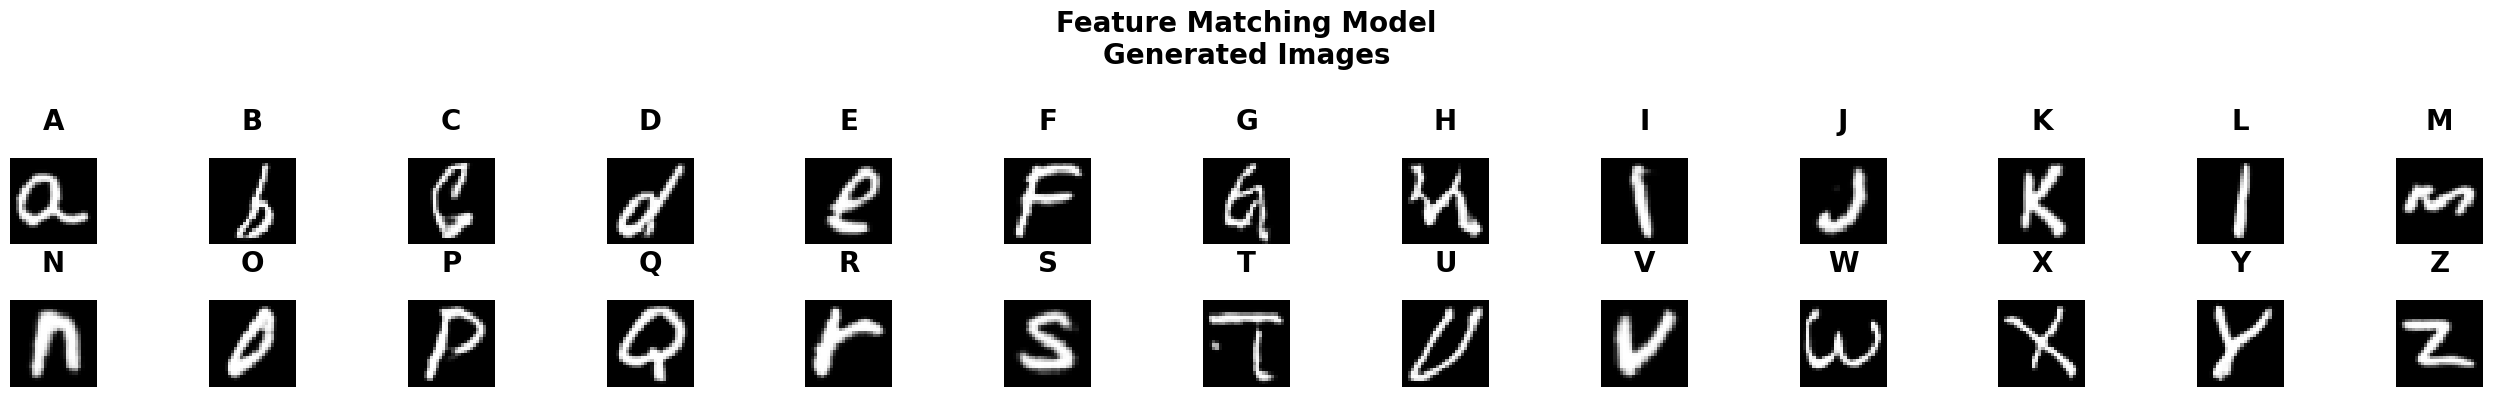

Model >> Time for epoch 100 is 26.74 sec


In [12]:
GANFeatureMatching = ImprovedArchitecture_With_FeatureMatching(
    noise_dim=100,
    num_examples_to_generate=26,
    epochs=100,
    batch_size=BATCH_SIZE,
    num_classes=26,
)
GANFeatureMatching.train(dataset_train)

**<u>Observation</u>**:
- letters like `'g'`, `'j'`, `'w'`, & `'x'` might need further refinement to be more recognizable.
- The feature matching GAN seems to generalize better across different letters. The model appears to have a better understanding of the structural features of the alphabet, leading to more coherent and accurate letter formations.

<hr>

# **Importing & Evaluating Model**

In [23]:
GANFeatureMatching.classifier.load_weights('./CA2-Model/GAN/FeatureMatching/classifier_FeatureMatching.h5')
GANFeatureMatching.generator.load_weights('./CA2-Model/GAN/FeatureMatching/discriminator_FeatureMatching.h5')
GANFeatureMatching.discriminator.load_weights('./CA2-Model/GAN/FeatureMatching/discriminator_FeatureMatching.h5')

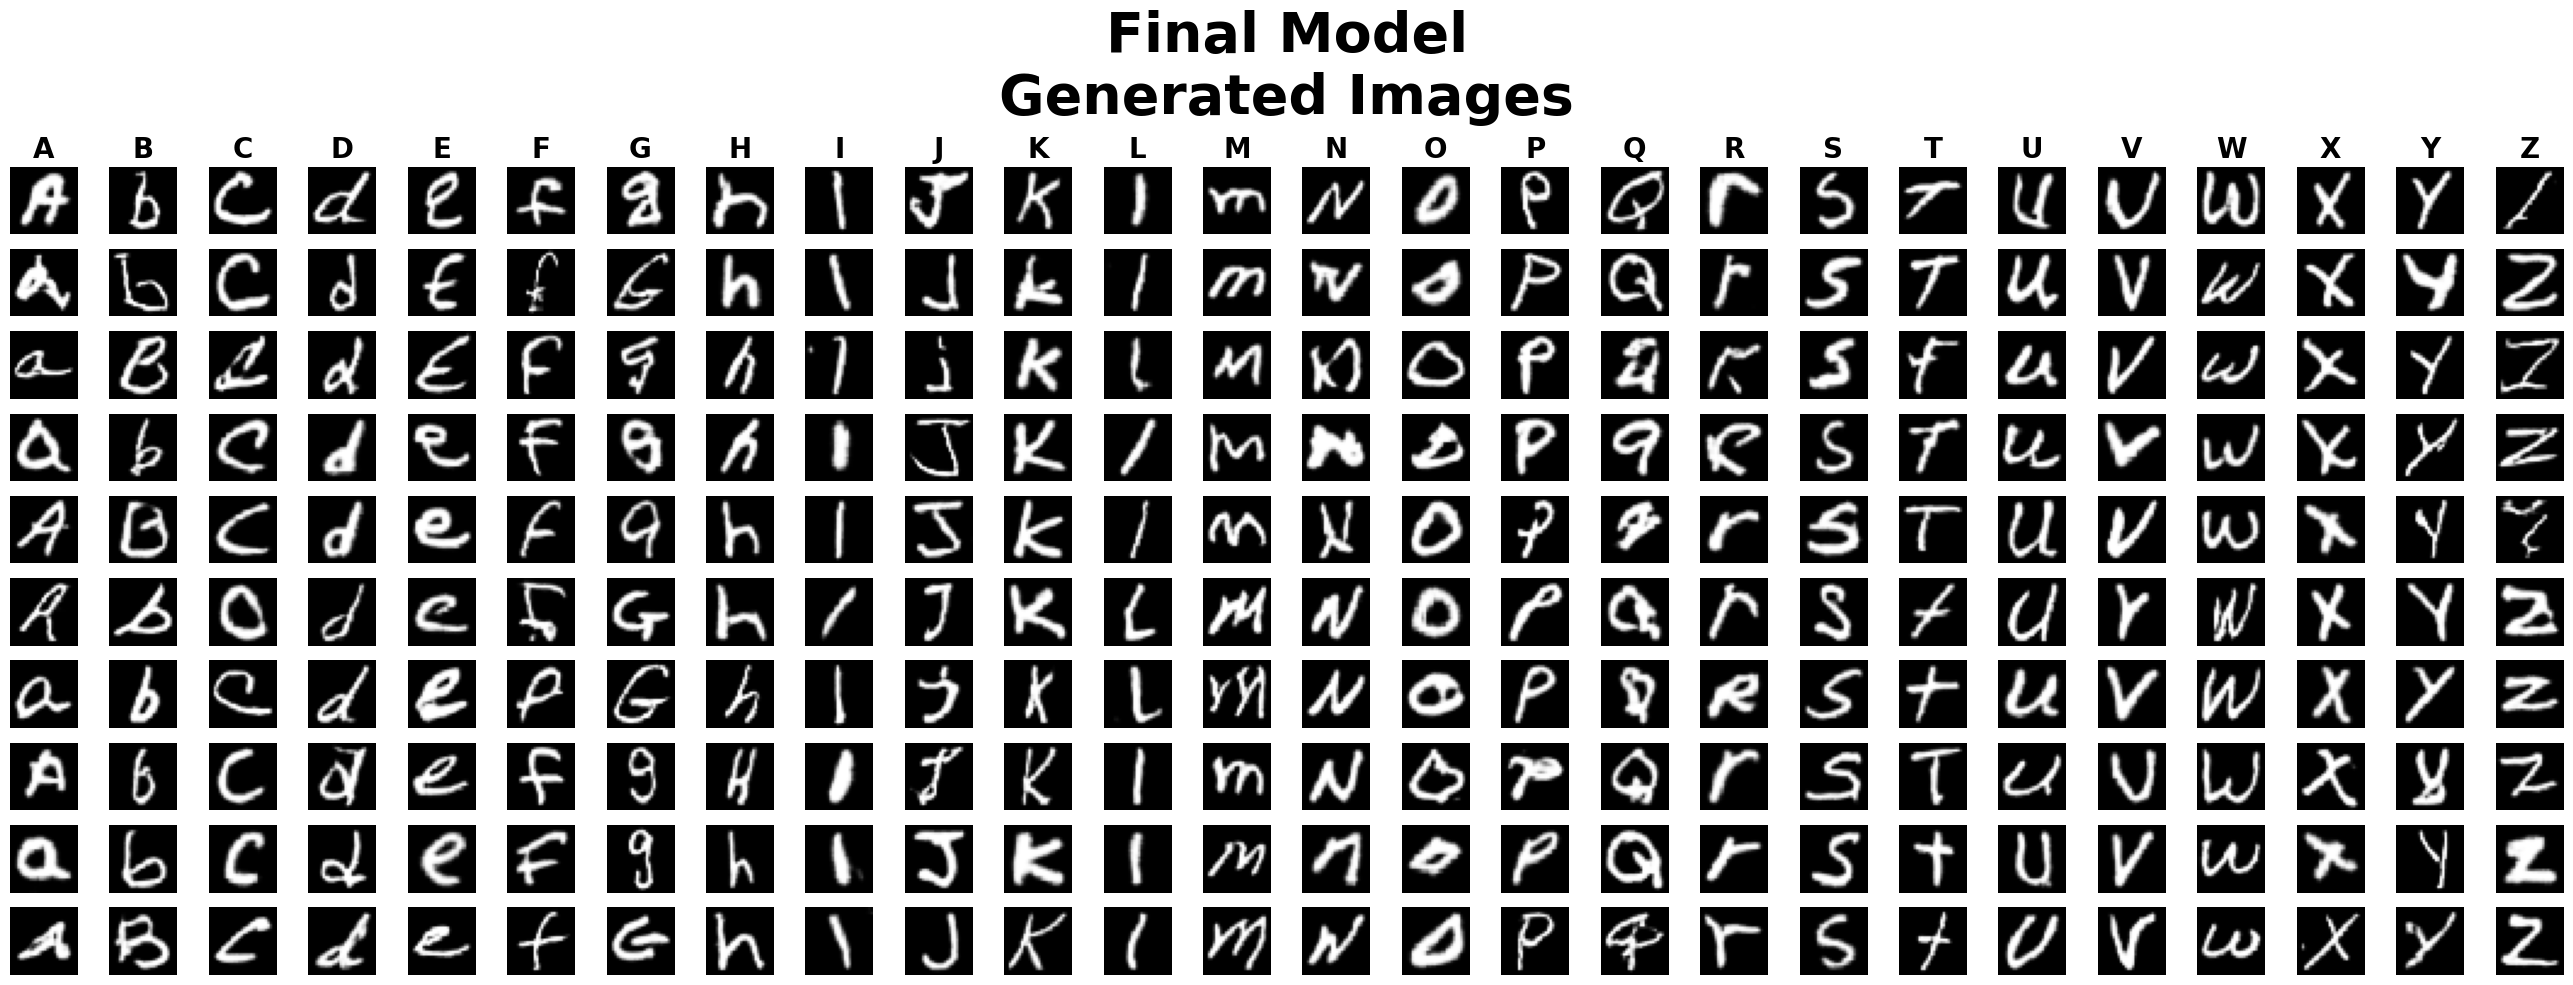

In [78]:
def generate_class_images(model, num_images_per_class):
    generated_images = []
    for class_label in range(26):
        noise = tf.random.normal([num_images_per_class, 100])
        labels = tf.one_hot(tf.ones((num_images_per_class,), dtype=tf.int32) * class_label, 26)
        images = model.generator([noise, labels], training=False)
        generated_images.append(images)
    return np.concatenate(generated_images)

# Generate images
num_images_per_class = 10
generated_images = generate_class_images(GANFeatureMatching, num_images_per_class)

# Plot the generated images
num_classes = 26
fig, ax = plt.subplots(num_images_per_class, num_classes, figsize=(26, 10))
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

for class_idx in range(num_classes):
    for row in range(num_images_per_class):
        img_idx = ((class_idx + 1) % num_classes) * num_images_per_class + row
        ax[row][class_idx].imshow(generated_images[img_idx, :, :, 0], cmap='gray')
        ax[row][class_idx].axis('off')
    ax[0][class_idx].set_title(letters[class_idx], fontsize=20, fontweight='bold')

plt.suptitle(f"Final Model\nGenerated Images", fontsize=40, fontweight='bold')
plt.tight_layout()
plt.show()

In [79]:
total_correct = 0
total_samples = 0
all_true_labels = []
all_predicted_labels = []

for images, labels in dataset_train:
    predicted_logits = GANFeatureMatching.classifier(images, training=False)
    predicted_labels = tf.argmax(predicted_logits, axis=1)
    total_correct += tf.reduce_sum(tf.cast(predicted_labels == labels, tf.int32))
    total_samples += images.shape[0]
    all_true_labels.extend(labels.numpy())
    all_predicted_labels.extend(predicted_labels.numpy())

# Calculate accuracy
accuracy = total_correct / total_samples
print(f"Classifier Accuracy: {accuracy:.2f}")

Classifier Accuracy: 0.92


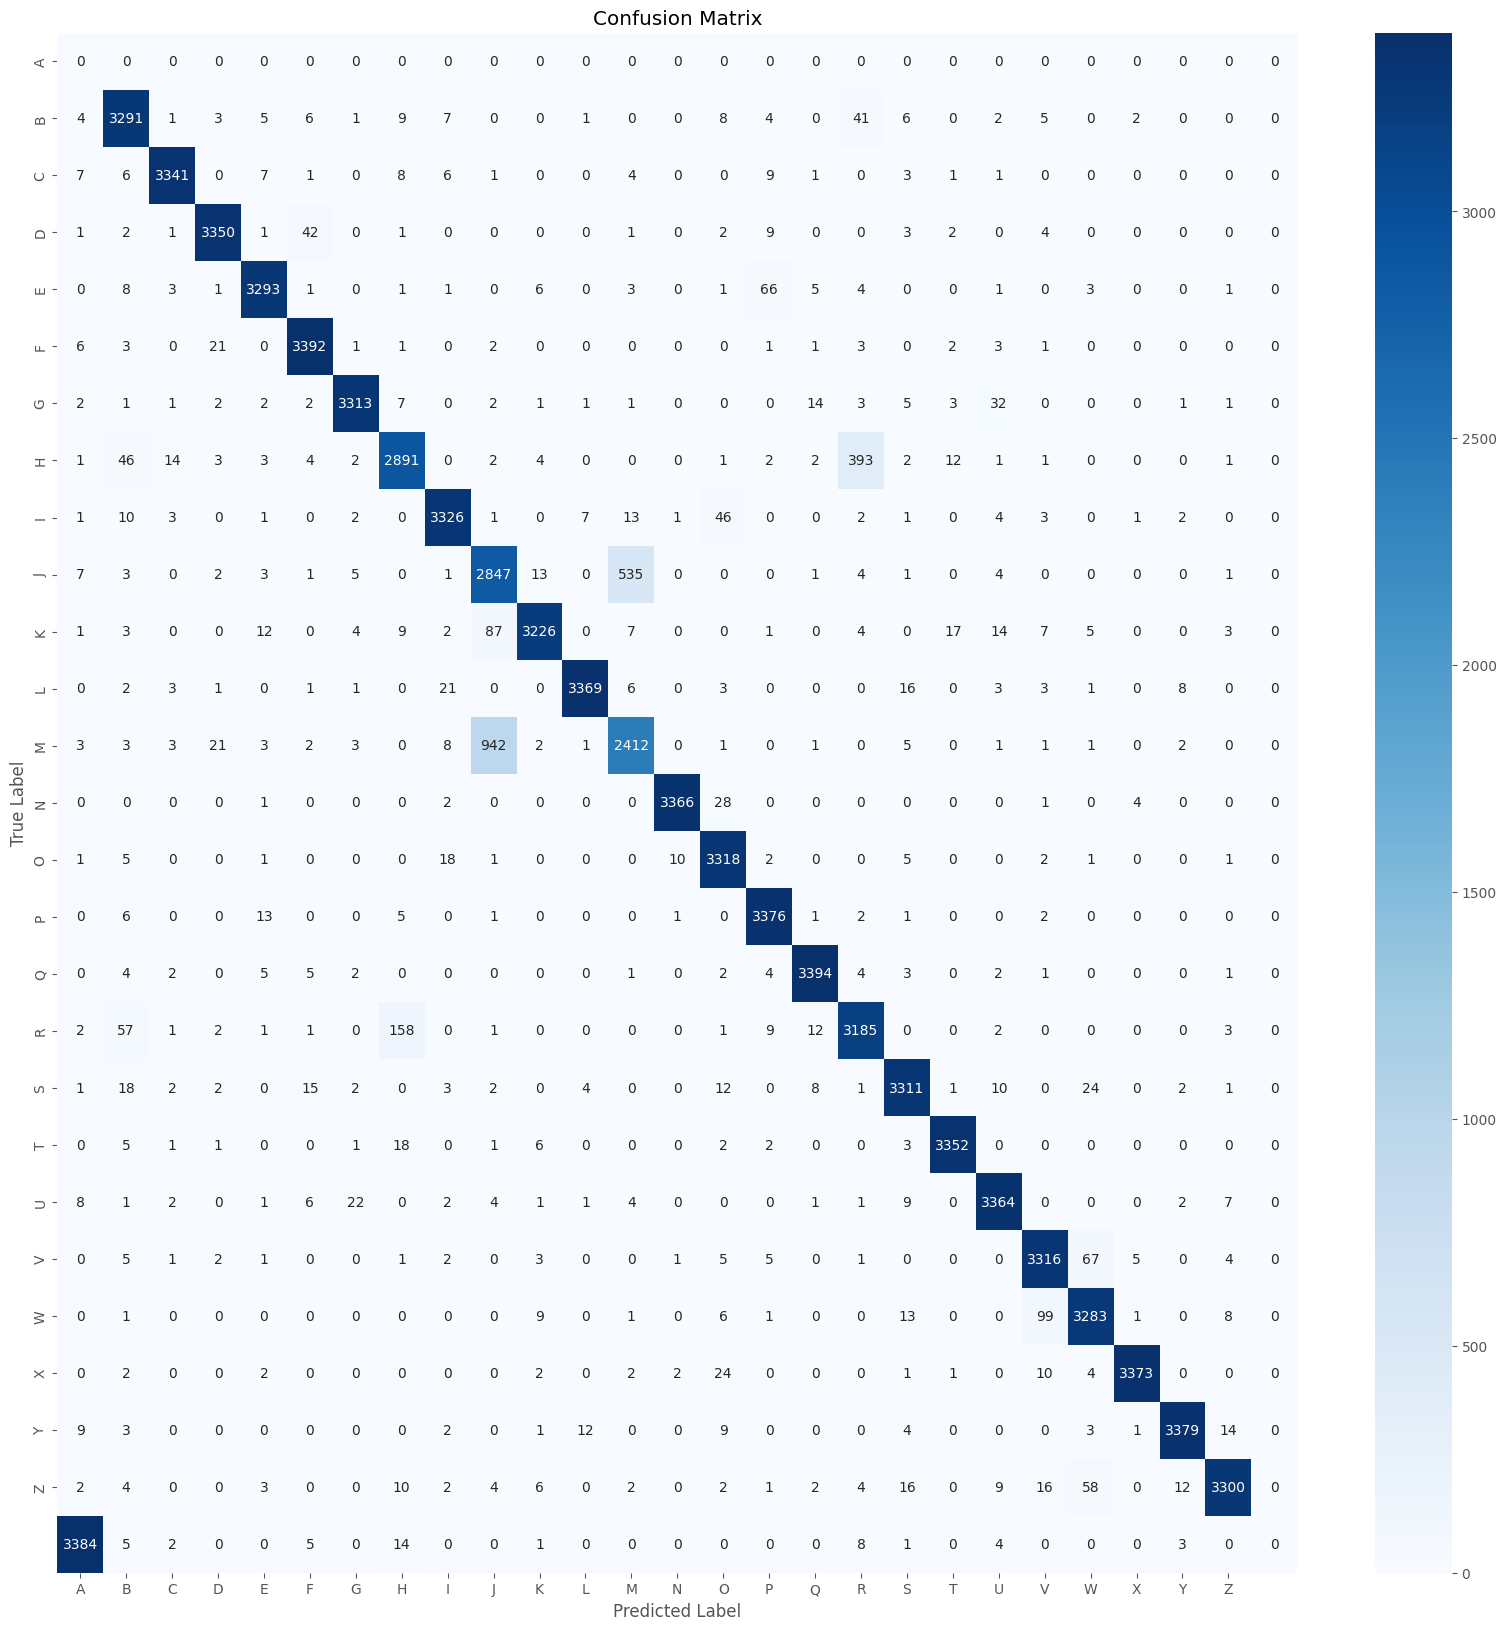

In [80]:
cm = confusion_matrix(all_true_labels, all_predicted_labels)

def plot_confusion_matrix(cm, true_classes, predicted_classes):
    plt.figure(figsize=(20,20))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=predicted_classes, yticklabels=true_classes, cbar=True)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

class_names = [chr(65 + i) for i in range(GANFeatureMatching.num_classes)]
plot_confusion_matrix(cm, class_names, class_names)

<hr>

# **Conclusions**
<hr>

### **1. Generating Images of a Specific Class**
- Use of TripleGAN / cGAN as they can take in labels of the images
- Train the DCGAN on each class `seperately`

### **2. Generating Colored Images vs. Black-and-White Images**
Generating colored images is generally harder than generating black-and-white images:
- Complexity: Colored images have more complex data structures, with three channels (RGB) instead of one. This increases the amount of information the GAN needs to learn.
- Model Size: The generator and discriminator models need to be larger and more complex to handle the additional data, requiring more computational resources and longer training times.
- Training Stability: The additional complexity can make the training process more unstable, requiring more careful tuning of hyperparameters and regularization techniques.
- Quality Metrics: Evaluating the quality of colored images can be more challenging, as color fidelity and consistency need to be taken into account.

If the `colours` show different `features` of the class, the **discriminator** can **easily** take note of it. Hence, may cause a lot of `model colapse`.
However, it could be easier for the generator to produce better quality results faster as each colour caa distinctly detect the feature of the classs

### **3. Classes That Are Relatively Easier/Harder to Generate**
- Easier Classes: Simple, well-defined characters with fewer strokes, such as 'I', 'L', 'O', and 'T'. These letters have less complexity and are easier for the GAN to learn and reproduce accurately.
- Harder Classes: More complex characters with multiple strokes and curves, such as 'M', 'W', 'K', and 'R'. These letters have more intricate details, making them harder for the GAN to generate accurately.

However, its not just about the strokes, our dataset has both uppercase & lowercase letters. <br>
The blurier the images, the more complex the class is.<br><br>
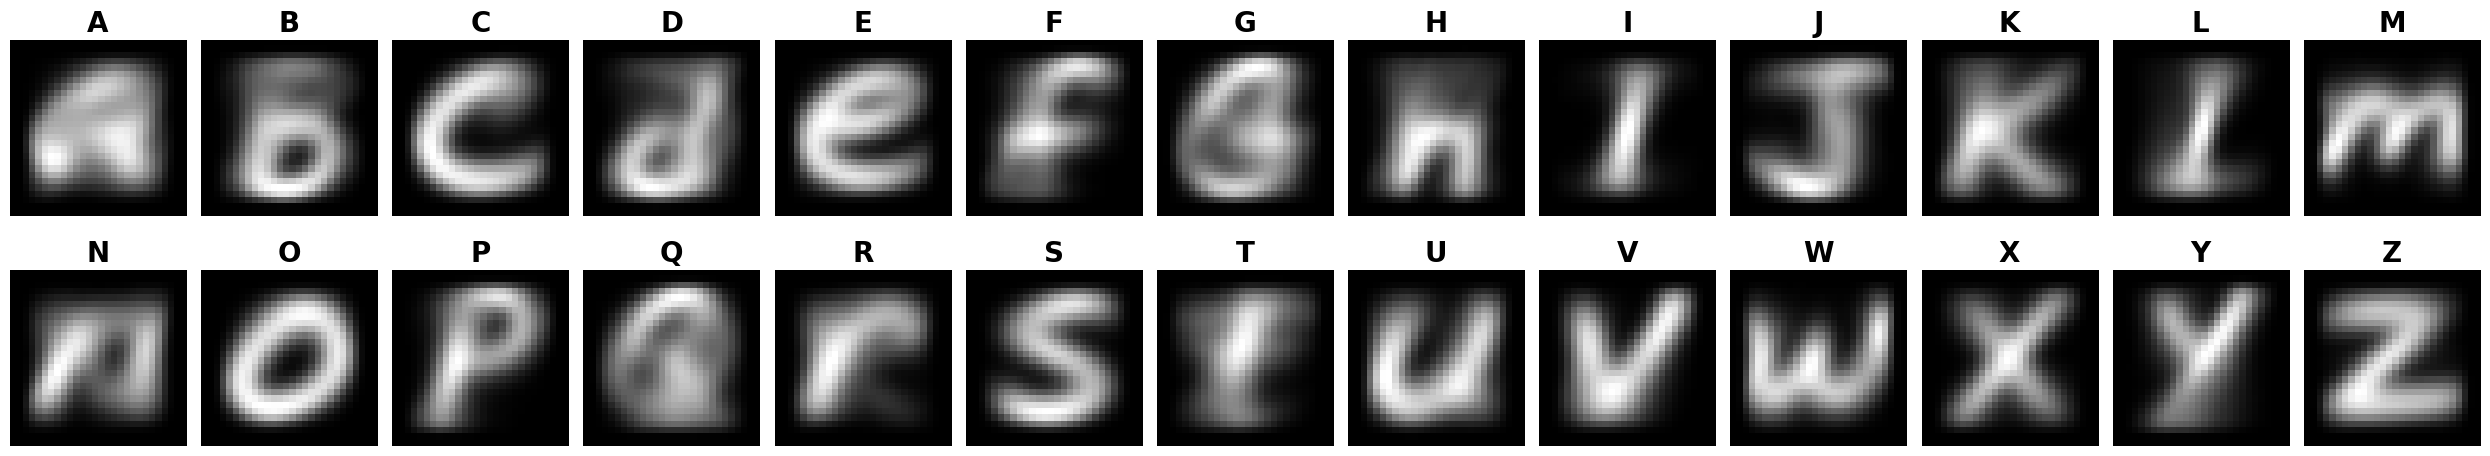<br><br>
Hence, it may be harder for the generator to decide which case to choose from. <br>
This is why we use TripleGAN which increases its diversity with the dataset
<br><br>
<hr>